In [ ]:
library(tidyverse)
library(jsonlite)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




Define the list of JSON files we want to process.

In [ ]:
json_files_to_load <- c(
    "gemini-3-pro-preview 1.json",
    "gemini-2.5-pro 1.json",
    "gpt-5 1.json",
    "gpt-5.1 1.json",
    "deepseek-r1 1.json",
    "gpt-oss-120b 1.json"
)

all_dfs <- list()

Iterate through each specified JSON file, load its content into a data frame, extract the model name, and append it to our list of data frames.

In [ ]:
for (filename in json_files_to_load) {
  file_path <- file.path('/content/', filename)
  if (file.exists(file_path)) {
    cat(paste0("Processing file: ", filename, "\n"))
    tryCatch({
      data <- fromJSON(file_path)
      df <- as.data.frame(data)

      # Extract model name (e.g., 'gemini-3-pro-preview' from 'gemini-3-pro-preview 1.json')
      model_name <- sub("\\.json$", "", filename)
      model_name <- sub(" 1$", "", model_name)
      df$model_name <- model_name
      all_dfs[[filename]] <- df
      cat(paste0("  Successfully loaded and processed ", filename, "\n"))
    }, error = function(e) {
      cat(paste0("  Error processing '", filename, "': ", e$message, "\n"))
    })
  } else {
    cat(paste0("  Warning: File '", filename, "' not found at ", file_path, "\n"))
  }
}

cat(paste0("\nTotal DataFrames loaded: ", length(all_dfs), "\n"))

Processing file: gemini-3-pro-preview 1.json
  Successfully loaded and processed gemini-3-pro-preview 1.json
Processing file: gemini-2.5-pro 1.json
  Successfully loaded and processed gemini-2.5-pro 1.json
Processing file: gpt-5 1.json
  Successfully loaded and processed gpt-5 1.json
Processing file: gpt-5.1 1.json
  Successfully loaded and processed gpt-5.1 1.json
Processing file: deepseek-r1 1.json
  Successfully loaded and processed deepseek-r1 1.json
Processing file: gpt-oss-120b 1.json
  Successfully loaded and processed gpt-oss-120b 1.json

Total DataFrames loaded: 6


Concatenate all individual DataFrames into a single one and display its head and general information.

In [ ]:
if (length(all_dfs) > 0) {
  unified_df <- bind_rows(all_dfs)
  cat("\nUnified DataFrame Head:\n")
  print(head(unified_df))

  cat("\nUnified DataFrame Structure:\n")
  str(unified_df)
} else {
  cat("No DataFrames were loaded. The unified DataFrame cannot be created.\n")
}


Unified DataFrame Head:
  alto.precision alto.recall alto.f1-score alto.support bajo.precision
1      0.9557522   0.9818182     0.9686099          110      0.9607843
2      0.9557522   0.9818182     0.9686099          110      0.9607843
3      0.9727273   0.9727273     0.9727273          110      0.9444444
4      0.9724771   0.9636364     0.9680365          110      0.9272727
5      0.9727273   0.9727273     0.9727273          110      0.9444444
6      0.8059701   0.9818182     0.8852459          110      0.9333333
  bajo.recall bajo.f1-score bajo.support  accuracy macro avg.precision
1   0.9074074     0.9333333           54 0.9573171           0.9582683
2   0.9074074     0.9333333           54 0.9573171           0.9582683
3   0.9444444     0.9444444           54 0.9634146           0.9585859
4   0.9444444     0.9357798           54 0.9573171           0.9498749
5   0.9444444     0.9444444           54 0.9634146           0.9585859
6   0.5185185     0.6666667           54 0.8292683  

In [ ]:
# --- Process 'accuracy' ---
accuracy_df <- unified_df %>%
  select(model_name, accuracy) %>%
  group_by(model_name) %>%
  summarise(
    accuracy_mean = mean(accuracy, na.rm = TRUE),
    accuracy_sd = sd(accuracy, na.rm = TRUE)
  )

# --- Process 'alto' ---
alto_metrics_df <- unified_df %>%
  unnest_wider(alto, names_sep = "_") %>%
  select(model_name, alto_precision, alto_recall, `alto_f1-score`, alto_support) %>%
  group_by(model_name) %>%
  summarise(
    alto_precision_mean = mean(alto_precision, na.rm = TRUE),
    alto_precision_sd = sd(alto_precision, na.rm = TRUE),
    alto_recall_mean = mean(alto_recall, na.rm = TRUE),
    alto_recall_sd = sd(alto_recall, na.rm = TRUE),
    alto_f1_score_mean = mean(`alto_f1-score`, na.rm = TRUE),
    alto_f1_score_sd = sd(`alto_f1-score`, na.rm = TRUE),
    alto_support_mean = mean(alto_support, na.rm = TRUE),
    alto_support_sd = sd(alto_support, na.rm = TRUE)
  )

# --- Process 'bajo' ---
bajo_metrics_df <- unified_df %>%
  unnest_wider(bajo, names_sep = "_") %>%
  select(model_name, bajo_precision, bajo_recall, `bajo_f1-score`, bajo_support) %>%
  group_by(model_name) %>%
  summarise(
    bajo_precision_mean = mean(bajo_precision, na.rm = TRUE),
    bajo_precision_sd = sd(bajo_precision, na.rm = TRUE),
    bajo_recall_mean = mean(bajo_recall, na.rm = TRUE),
    bajo_recall_sd = sd(bajo_recall, na.rm = TRUE),
    bajo_f1_score_mean = mean(`bajo_f1-score`, na.rm = TRUE),
    bajo_f1_score_sd = sd(`bajo_f1-score`, na.rm = TRUE),
    bajo_support_mean = mean(bajo_support, na.rm = TRUE),
    bajo_support_sd = sd(bajo_support, na.rm = TRUE)
  )

# --- Process 'macro avg' ---
macro_avg_metrics_df <- unified_df %>%
  unnest_wider(`macro avg`, names_sep = "_") %>%
  select(model_name, `macro avg_precision`, `macro avg_recall`, `macro avg_f1-score`, `macro avg_support`) %>%
  group_by(model_name) %>%
  summarise(
    macro_avg_precision_mean = mean(`macro avg_precision`, na.rm = TRUE),
    macro_avg_precision_sd = sd(`macro avg_precision`, na.rm = TRUE),
    macro_avg_recall_mean = mean(`macro avg_recall`, na.rm = TRUE),
    macro_avg_recall_sd = sd(`macro avg_recall`, na.rm = TRUE),
    macro_avg_f1_score_mean = mean(`macro avg_f1-score`, na.rm = TRUE),
    macro_avg_f1_score_sd = sd(`macro avg_f1-score`, na.rm = TRUE),
    macro_avg_support_mean = mean(`macro avg_support`, na.rm = TRUE),
    macro_avg_support_sd = sd(`macro avg_support`, na.rm = TRUE)
  )

# --- Process 'weighted avg' ---
weighted_avg_metrics_df <- unified_df %>%
  unnest_wider(`weighted avg`, names_sep = "_") %>%
  select(model_name, `weighted avg_precision`, `weighted avg_recall`, `weighted avg_f1-score`, `weighted avg_support`) %>%
  group_by(model_name) %>%
  summarise(
    weighted_avg_precision_mean = mean(`weighted avg_precision`, na.rm = TRUE),
    weighted_avg_precision_sd = sd(`weighted avg_precision`, na.rm = TRUE),
    weighted_avg_recall_mean = mean(`weighted avg_recall`, na.rm = TRUE),
    weighted_avg_recall_sd = sd(`weighted avg_recall`, na.rm = TRUE),
    weighted_avg_f1_score_mean = mean(`weighted avg_f1-score`, na.rm = TRUE),
    weighted_avg_f1_score_sd = sd(`weighted avg_f1-score`, na.rm = TRUE),
    weighted_avg_support_mean = mean(`weighted avg_support`, na.rm = TRUE),
    weighted_avg_support_sd = sd(`weighted avg_support`, na.rm = TRUE)
  )

# Combine all results into a single list of data frames
all_model_stats <- list(
  accuracy = accuracy_df,
  alto = alto_metrics_df,
  bajo = bajo_metrics_df,
  macro_avg = macro_avg_metrics_df,
  weighted_avg = weighted_avg_metrics_df
)

# Print each data frame
cat("\n--- Accuracy Statistics ---\n")
print(all_model_stats$accuracy)

cat("\n--- Alto Statistics ---\n")
print(all_model_stats$alto)

cat("\n--- Bajo Statistics ---\n")
print(all_model_stats$bajo)

cat("\n--- Macro Avg Statistics ---\n")
print(all_model_stats$macro_avg)

cat("\n--- Weighted Avg Statistics ---\n")
print(all_model_stats$weighted_avg)


--- Accuracy Statistics ---
# A tibble: 6 × 3
  model_name           accuracy_mean accuracy_sd
  <chr>                        <dbl>       <dbl>
1 deepseek-r1                  0.830     0.00510
2 gemini-2.5-pro               0.815     0.0102 
3 gemini-3-pro-preview         0.960     0.00334
4 gpt-5                        0.916     0.0169 
5 gpt-5.1                      0.927     0.00964
6 gpt-oss-120b                 0.839     0.0200 

--- Alto Statistics ---
# A tibble: 6 × 9
  model_name           alto_precision_mean alto_precision_sd alto_recall_mean
  <chr>                              <dbl>             <dbl>            <dbl>
1 deepseek-r1                        0.807           0.00504            0.982
2 gemini-2.5-pro                     0.791           0.00969            0.984
3 gemini-3-pro-preview               0.966           0.00925            0.975
4 gpt-5                              0.902           0.0206             0.982
5 gpt-5.1                            0.920        

In [ ]:
bajo_metrics_df

model_name,bajo_precision_mean,bajo_precision_sd,bajo_recall_mean,bajo_recall_sd,bajo_f1_score_mean,bajo_f1_score_sd,bajo_support_mean,bajo_support_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
deepseek-r1,0.9337338,0.001852873,0.5222222,0.01549370,0.6697283,0.013259996,54,0
gemini-2.5-pro,0.9339194,0.016022449,0.4703704,0.03098741,0.6251626,0.027702141,54,0
gemini-3-pro-preview,0.9475460,0.013970959,0.9296296,0.02028602,0.9382671,0.005726907,54,0
gpt-5,0.9546025,0.002962523,0.7814815,0.05138680,0.8587295,0.032784841,54,0
gpt-5.1,0.9449843,0.011124663,0.8259259,0.02808472,0.8812445,0.017027756,54,0
gpt-oss-120b,0.9148186,0.017246469,0.5629630,0.05647389,0.6960323,0.047302881,54,0


## Prepare Data for Plotting

Load `ggplot2` and reshape the `all_model_stats` list into a format suitable for various visualizations.


Reshape the `accuracy_df` from `all_model_stats$accuracy` into a long format. This will involve selecting the relevant columns and using `pivot_longer` to create new columns for metric names and values, storing the result in `accuracy_long_df`.



In [ ]:
accuracy_long_df <- all_model_stats$accuracy %>%
  pivot_longer(
    cols = c(accuracy_mean, accuracy_sd),
    names_to = "metric",
    values_to = "value"
  ) %>%
  mutate(metric = sub("accuracy_", "", metric))

cat("\n--- Accuracy Long Format ---\n")
print(head(accuracy_long_df))


--- Accuracy Long Format ---
# A tibble: 6 × 3
  model_name           metric   value
  <chr>                <chr>    <dbl>
1 deepseek-r1          mean   0.830  
2 deepseek-r1          sd     0.00510
3 gemini-2.5-pro       mean   0.815  
4 gemini-2.5-pro       sd     0.0102 
5 gemini-3-pro-preview mean   0.960  
6 gemini-3-pro-preview sd     0.00334


Reshape the `macro_avg_metrics_df` into a long format suitable for plotting. This involves pivoting columns to create separate columns for metric names, mean values, and standard error values, as specified in the instructions.



In [ ]:
macro_avg_long_df <- all_model_stats$macro_avg %>%
  pivot_longer(
    cols = -model_name,
    names_to = c("metric", ".value"),
    names_pattern = "macro_avg_(.*)_(mean|sd)"
  ) %>%
  rename(mean = "mean", sd = "sd") # Rename .value columns for clarity

cat("\n--- Macro Avg Long Format ---\n")
print(head(macro_avg_long_df))



--- Macro Avg Long Format ---
# A tibble: 6 × 4
  model_name     metric       mean      sd
  <chr>          <chr>       <dbl>   <dbl>
1 deepseek-r1    precision   0.870 0.00345
2 deepseek-r1    recall      0.752 0.00775
3 deepseek-r1    f1_score    0.778 0.00815
4 deepseek-r1    support   164     0      
5 gemini-2.5-pro precision   0.862 0.0102 
6 gemini-2.5-pro recall      0.727 0.0154 


Reshape the `weighted_avg_metrics_df` into a long format, creating columns for metric names, mean values, and standard error values, as specified in the instructions. This will prepare the data for subsequent visualization.



In [ ]:
weighted_avg_long_df <- all_model_stats$weighted_avg %>%
  pivot_longer(
    cols = -model_name,
    names_to = c("metric", ".value"),
    names_pattern = "weighted_avg_(.*)_(mean|sd)"
  ) %>%
  rename(mean = "mean", sd = "sd") # Rename .value columns for clarity

cat("\n--- Weighted Avg Long Format ---\n")
print(head(weighted_avg_long_df))


--- Weighted Avg Long Format ---
# A tibble: 6 × 4
  model_name     metric       mean      sd
  <chr>          <chr>       <dbl>   <dbl>
1 deepseek-r1    precision   0.849 0.00399
2 deepseek-r1    recall      0.830 0.00510
3 deepseek-r1    f1_score    0.815 0.00640
4 deepseek-r1    support   164     0      
5 gemini-2.5-pro precision   0.838 0.00916
6 gemini-2.5-pro recall      0.815 0.0102 


Reshape the `alto_metrics_df` and `bajo_metrics_df` into a single long format suitable for faceting, including class, metric names (specifically 'f1-score'), mean values, and standard error values. This will prepare the data for the F1-score by class plot.



In [ ]:
f1_score_by_class_long_df <- bind_rows(
  all_model_stats$alto %>%
    select(model_name, alto_f1_score_mean, alto_f1_score_sd) %>%
    rename(mean = alto_f1_score_mean, sd = alto_f1_score_sd) %>%
    mutate(class = "alto", metric = "f1_score"),
  all_model_stats$bajo %>%
    select(model_name, bajo_f1_score_mean, bajo_f1_score_sd) %>%
    rename(mean = bajo_f1_score_mean, sd = bajo_f1_score_sd) %>%
    mutate(class = "bajo", metric = "f1_score")
)

cat("\n--- F1-score by Class Long Format ---\n")
print(head(f1_score_by_class_long_df))


--- F1-score by Class Long Format ---
# A tibble: 6 × 5
  model_name            mean      sd class metric  
  <chr>                <dbl>   <dbl> <chr> <chr>   
1 deepseek-r1          0.886 0.00304 alto  f1_score
2 gemini-2.5-pro       0.877 0.00604 alto  f1_score
3 gemini-3-pro-preview 0.970 0.00237 alto  f1_score
4 gpt-5                0.940 0.0113  alto  f1_score
5 gpt-5.1              0.947 0.00670 alto  f1_score
6 gpt-oss-120b         0.890 0.0124  alto  f1_score


## Plot: Grouped Bar Plot for Weighted Averaged Metrics

### Subtask:
Create a grouped bar plot comparing `weighted_avg_precision_mean`, `weighted_avg_recall_mean`, and `weighted_avg_f1_score_mean` across models, including error bars for each metric.

## Plot 4: Facetted Bar Plot for F1-Score by Class

### Subtask:
Create a facetted bar plot showing `alto_f1_score_mean` and `bajo_f1_score_mean` for each model, with error bars, faceted by class.

## Plot 4: Facetted Bar Plot for F1-Score by Class

### Subtask:
Create a facetted bar plot showing `alto_f1_score_mean` and `bajo_f1_score_mean` for each model, with error bars, faceted by class.

Generate a facetted bar plot to visualize the mean F1-scores for 'alto' and 'bajo' classes across different models, including error bars to indicate standard error.



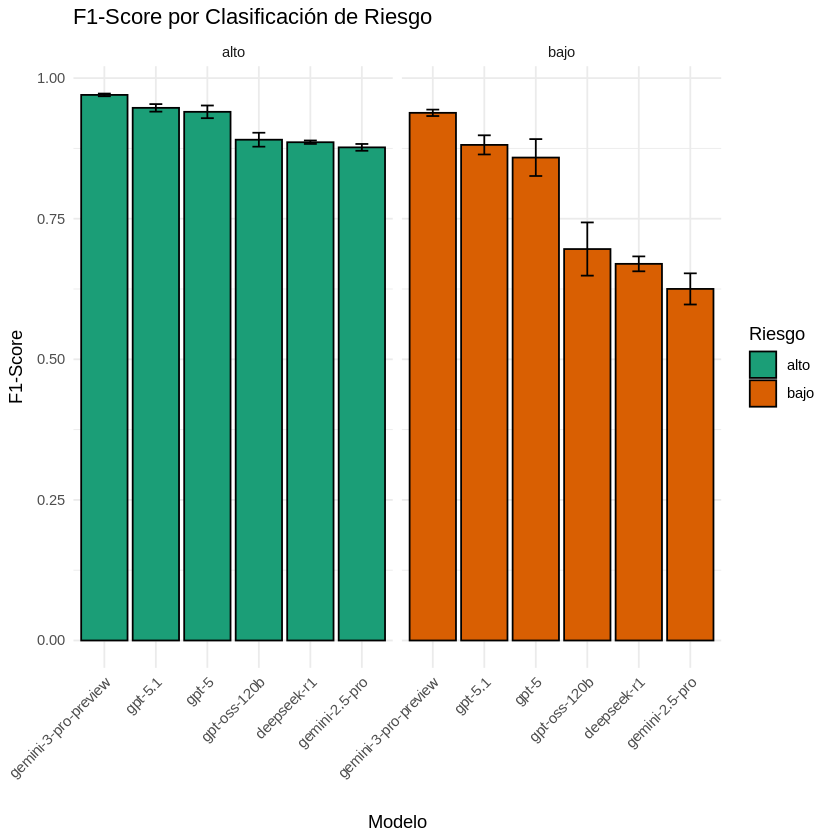

In [ ]:
f1_score_by_class_plot <- ggplot(f1_score_by_class_long_df, aes(x = reorder(model_name, -mean), y = mean, fill = class)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.75), color = "black") +
  geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd), position = position_dodge(width = 0.75), width = 0.25) +
  facet_wrap(~ class, scales = "free_x") +
  labs(
    x = "Modelo",
    y = "F1-Score",
    title = "F1-Score por Clasificación de Riesgo",
    fill = "Riesgo"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_brewer(palette = "Dark2")

print(f1_score_by_class_plot)

In [ ]:
jpeg("f1_score_by_class_plot.jpg", width = 20, height = 15, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
print(f1_score_by_class_plot)
dev.off()

agg_record_1940200281 
                    2

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



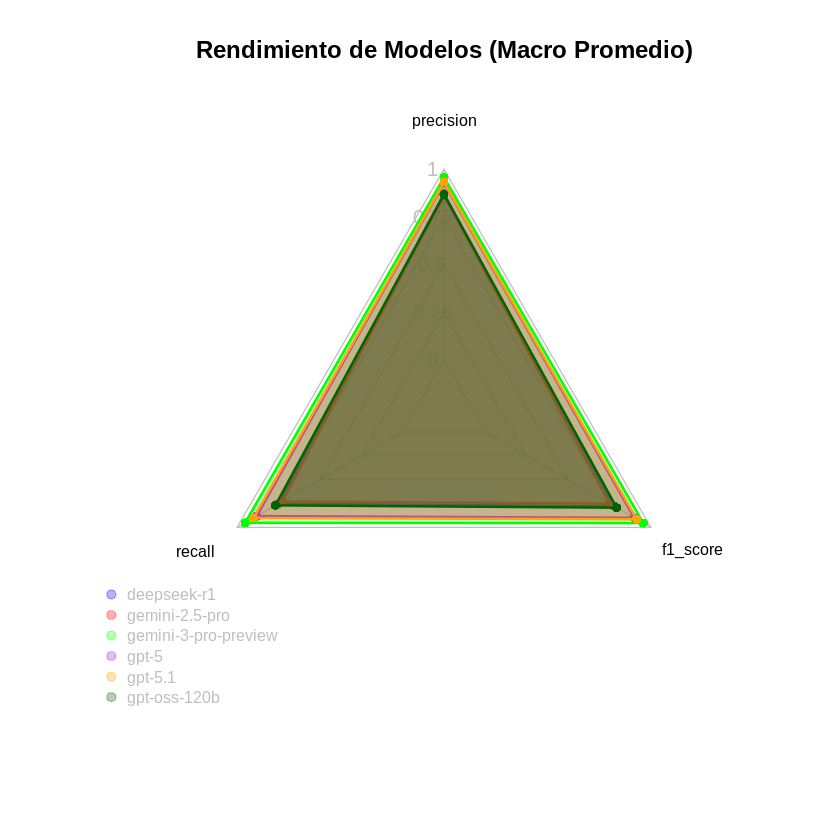

In [ ]:
install.packages("fmsb")
library(fmsb) # Load the fmsb package for radar plots

# Prepare data for radar chart: select relevant metrics (precision, recall, f1_score)
# from macro_avg_long_df and pivot wider.
radar_data <- macro_avg_long_df %>%
  filter(metric %in% c("precision", "recall", "f1_score")) %>%
  pivot_wider(
    id_cols = model_name,
    names_from = metric,
    values_from = mean
  )

# Ensure all metrics are present, if not, fill with NA (or 0 if preferred)
# And reorder columns if necessary to a consistent order for the plot
radar_data <- radar_data %>%
  select(model_name, precision, recall, f1_score)

# Prepare the data frame for radarchart: it needs max and min values as the first two rows
max_min_values <- data.frame(
  model_name = c("max", "min"),
  precision = c(1, 0),
  recall = c(1, 0),
  f1_score = c(1, 0)
)

# Combine max/min with the actual model data
radar_chart_data <- rbind(max_min_values, radar_data)

# Convert to a matrix for radarchart, excluding the model_name column
radar_chart_matrix <- as.data.frame(radar_chart_data[, -1])

# Set colors and line types for each model
colors_border <- c("blue", "red", "green", "purple", "orange", "darkgreen")
colors_in <- scales::alpha(colors_border, 0.3)

# Create the radar chart
# Note: you might need to adjust the cglcol, caxislabels, pty parameters
# for better readability depending on the number of models and labels.
radarchart(
  radar_chart_matrix,
  axistype = 1,
  # Customize plot
  pcol = colors_border,
  pfcol = colors_in,
  plwd = 2,
  plty = 1,
  cglcol = "grey",
  cglty = 1,
  axislabcol = "grey",
  vlcex = 0.8,
  # Add custom axis labels
  caxislabels = c(0, 0.25, 0.5, 0.75, 1),
  # Title
  title = "Rendimiento de Modelos (Macro Promedio)"
)

# Add a legend
legend(
  x = "bottomleft",
  legend = radar_data$model_name,
  bty = "n",
  pch = 20,
  col = colors_in,
  text.col = "grey",
  cex = 0.8,
  pt.cex = 1.5
)


In [ ]:
radar_chart_data

model_name,precision,recall,f1_score
<chr>,<dbl>,<dbl>,<dbl>
max,1.0000000,1.0000000,1.0000000
min,0.0000000,0.0000000,0.0000000
deepseek-r1,0.8704669,0.7520202,0.7778544
gemini-2.5-pro,0.8624757,0.7270034,0.7510075
gemini-3-pro-preview,0.9567166,0.9520875,0.9542046
gpt-5,0.9282436,0.8816498,0.8993931
gpt-5.1,0.9323159,0.9011448,0.9141818
gpt-oss-120b,0.8673634,0.7687542,0.7932555


NULL


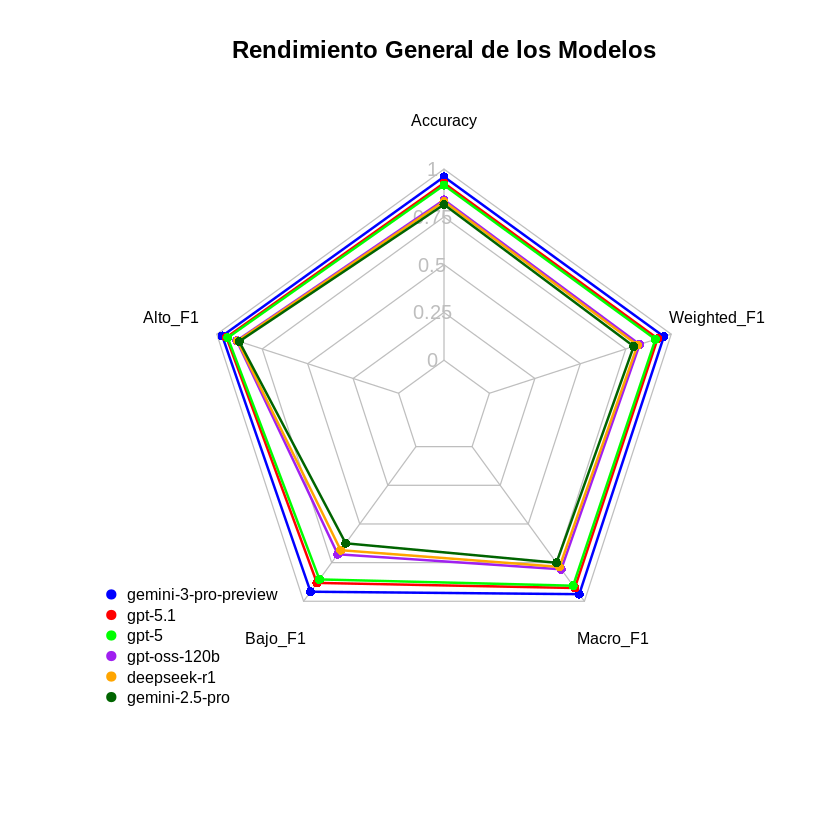

In [ ]:
library(dplyr)
library(tidyr)
library(fmsb) # Ensure fmsb is loaded for radarchart

# 1. Get accuracy_mean
df_accuracy <- all_model_stats$accuracy %>%
  select(model_name, accuracy_mean)

# 2. Get alto_f1_score_mean
df_alto_f1 <- all_model_stats$alto %>%
  select(model_name, alto_f1_score_mean)

# 3. Get bajo_f1_score_mean
df_bajo_f1 <- all_model_stats$bajo %>%
  select(model_name, bajo_f1_score_mean)

# 4. Get macro_avg_f1_score_mean
df_macro_f1 <- all_model_stats$macro_avg %>%
  select(model_name, macro_avg_f1_score_mean)

# 5. Get weighted_avg_f1_score_mean
df_weighted_f1 <- all_model_stats$weighted_avg %>%
  select(model_name, weighted_avg_f1_score_mean)

# Combine all into one dataframe
radar_data_all_metrics <- df_accuracy %>%
  left_join(df_alto_f1, by = "model_name") %>%
  left_join(df_bajo_f1, by = "model_name") %>%
  left_join(df_macro_f1, by = "model_name") %>%
  left_join(df_weighted_f1, by = "model_name")

# Rename columns for better readability in the plot
radar_data_all_metrics <- radar_data_all_metrics %>%
  rename(
    Accuracy = accuracy_mean,
    Alto_F1 = alto_f1_score_mean,
    Bajo_F1 = bajo_f1_score_mean,
    Macro_F1 = macro_avg_f1_score_mean,
    Weighted_F1 = weighted_avg_f1_score_mean
  )

# Sort radar_data_all_metrics by Accuracy so plot lines are drawn in this order
radar_data_all_metrics_sorted <- radar_data_all_metrics %>%
  arrange(desc(Accuracy))

# Prepare the data frame for radarchart: it needs max and min values as the first two rows
max_min_values_all <- data.frame(
  model_name = c("max", "min"),
  Accuracy = c(1, 0),
  Alto_F1 = c(1, 0),
  Bajo_F1 = c(1, 0),
  Macro_F1 = c(1, 0),
  Weighted_F1 = c(1, 0)
)

# Combine max/min with the actual model data (now sorted by Accuracy)
radar_chart_data_all <- rbind(max_min_values_all, radar_data_all_metrics_sorted)

# Convert to a matrix for radarchart, excluding the model_name column
radar_chart_matrix_all <- as.data.frame(radar_chart_data_all[, -1])

# Set colors and line types for each model
# Assuming up to 6 models, you can extend this if needed
colors_border_all <- c("blue", "red", "green", "purple", "orange", "darkgreen")
# colors_in_all_leg is now derived from colors_border_all, which will match the plot lines
colors_in_all_leg <- scales::alpha(colors_border_all, 0.9)

# Create the radar chart
radar_plot <- radarchart(
  radar_chart_matrix_all,
  axistype = 1,
  # Customize plot
  pcol = colors_border_all, # Colors will now be applied to the sorted models
  # pfcol = colors_in_all,
  plwd = 2,
  plty = 1,
  cglcol = "grey",
  cglty = 1,
  axislabcol = "grey",
  vlcex = 0.8,
  # Add custom axis labels
  caxislabels = c(0, 0.25, 0.5, 0.75, 1),
  # Title
  title = "Rendimiento General de los Modelos"
)

# The legend should use the model names from the sorted data frame
legend(
  x = "bottomleft",
  legend = radar_data_all_metrics_sorted$model_name, # Use sorted names for legend text
  bty = "n",
  pch = 20,
  col = colors_border_all, # Use the same color sequence as pcol in radarchart
  text.col = "black",
  cex = 0.8,
  pt.cex = 1.5
)

print(radar_plot)


In [ ]:
radar_data_all_metrics_sorted

model_name,Accuracy,Alto_F1,Bajo_F1,Macro_F1,Weighted_F1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gemini-3-pro-preview,0.9597561,0.9701422,0.9382671,0.9542046,0.9596467
gpt-5.1,0.9268293,0.9471190,0.8812445,0.9141818,0.9254286
gpt-5,0.9158537,0.9400567,0.8587295,0.8993931,0.9132782
gpt-oss-120b,0.8390244,0.8904787,0.6960323,0.7932555,0.8264537
deepseek-r1,0.8304878,0.8859804,0.6697283,0.7778544,0.8147755
gemini-2.5-pro,0.8146341,0.8768525,0.6251626,0.7510075,0.7939790


In [ ]:
jpeg("radar_plot.jpg", width = 20, height = 15, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
radarchart(
  radar_chart_matrix_all,
  axistype = 1,
  # Customize plot
  pcol = colors_border_all, # Colors will now be applied to the sorted models
  # pfcol = colors_in_all,
  plwd = 2,
  plty = 1,
  cglcol = "grey",
  cglty = 1,
  axislabcol = "grey",
  vlcex = 0.8,
  # Add custom axis labels
  caxislabels = c(0, 0.25, 0.5, 0.75, 1),
  # Title
  title = "Rendimiento General de los Modelos"
)

# The legend should use the model names from the sorted data frame
legend(
  x = "bottomleft",
  legend = radar_data_all_metrics_sorted$model_name, # Use sorted names for legend text
  bty = "n",
  pch = 20,
  col = colors_border_all, # Use the same color sequence as pcol in radarchart
  text.col = "black",
  cex = 0.8,
  pt.cex = 1.5
)
dev.off()


agg_record_639333024 
                   2

# Task
List all Excel files in the '/content/' directory, then load each Excel file, extract the model name from its filename, add a new column 'modelo' with this name to each data frame, and finally combine all processed data frames into a single unified data frame.

## List Excel Files

### Subtask:
Identify and list all relevant Excel files in the '/content/' directory that need to be processed.


To identify and list all relevant Excel files in the '/content/' directory, I will use `list.files()` to get all files and then filter for those with the '.xlsx' extension, storing them in `excel_files_to_load`.



In [ ]:
excel_files_to_load <- list.files(path = "/content/", pattern = "\\.xlsx$", full.names = FALSE)

if (length(excel_files_to_load) == 0) {
  cat("No Excel files found in the /content/ directory.")
} else {
  cat("Identified Excel files to load:\n")
  print(excel_files_to_load)
}

Identified Excel files to load:
[1] "deepseek-r1 1.xlsx"          "gemini-2.5-pro 1.xlsx"      
[3] "gemini-3-pro-preview 1.xlsx" "gpt-5 1.xlsx"               
[5] "gpt-5.1 1.xlsx"              "gpt-oss-120b 1.xlsx"        


## Load and Process Each Excel File

### Subtask:
Iterate through the identified Excel files. For each file, load its content into a data frame, extract the model name from the filename, and add a new column named 'modelo' containing this name to the data frame.


The first step in processing the Excel files is to ensure the necessary `readxl` library is loaded.

In [ ]:
if (!requireNamespace("readxl", quietly = TRUE)) {
  install.packages("readxl")
}
library(readxl)
cat("readxl library loaded.\n")

readxl library loaded.


Iterate through the identified Excel files, load each into a data frame, extract the model name from the filename, add a 'modelo' column, and store the processed data frames in a list called `all_excel_dfs` as instructed.



In [ ]:
all_excel_dfs <- list()

for (filename in excel_files_to_load) {
  file_path <- file.path('/content/', filename)
  if (file.exists(file_path)) {
    cat(paste0("Processing Excel file: ", filename, "\n"))
    tryCatch({
      df_excel <- read_excel(file_path)

      # Extract model name (e.g., 'gemini-3-pro-preview' from 'gemini-3-pro-preview 1.xlsx')
      model_name <- sub("\\.xlsx$", "", filename)
      model_name <- sub(" 1$", "", model_name)
      df_excel$modelo <- model_name
      all_excel_dfs[[filename]] <- df_excel
      cat(paste0("  Successfully loaded and processed ", filename, "\n"))
    }, error = function(e) {
      cat(paste0("  Error processing '", filename, "': ", e$message, "\n"))
    })
  } else {
    cat(paste0("  Warning: Excel file '", filename, "' not found at ", file_path, "\n"))
  }
}

cat(paste0("\nTotal Excel DataFrames loaded: ", length(all_excel_dfs), "\n"))

Processing Excel file: deepseek-r1 1.xlsx


New names:
• `Riesgo` -> `Riesgo...14`
• `Riesgo` -> `Riesgo...15`


  Successfully loaded and processed deepseek-r1 1.xlsx
Processing Excel file: gemini-2.5-pro 1.xlsx


New names:
• `Riesgo` -> `Riesgo...14`
• `Riesgo` -> `Riesgo...15`


  Successfully loaded and processed gemini-2.5-pro 1.xlsx
Processing Excel file: gemini-3-pro-preview 1.xlsx


New names:
• `Riesgo` -> `Riesgo...14`
• `Riesgo` -> `Riesgo...15`


  Successfully loaded and processed gemini-3-pro-preview 1.xlsx
Processing Excel file: gpt-5 1.xlsx


New names:
• `Riesgo` -> `Riesgo...14`
• `Riesgo` -> `Riesgo...15`


  Successfully loaded and processed gpt-5 1.xlsx
Processing Excel file: gpt-5.1 1.xlsx


New names:
• `Riesgo` -> `Riesgo...14`
• `Riesgo` -> `Riesgo...15`


  Successfully loaded and processed gpt-5.1 1.xlsx
Processing Excel file: gpt-oss-120b 1.xlsx


New names:
• `Riesgo` -> `Riesgo...14`
• `Riesgo` -> `Riesgo...15`


  Successfully loaded and processed gpt-oss-120b 1.xlsx

Total Excel DataFrames loaded: 6


Now that all individual Excel data frames have been loaded and processed, combine them into a single unified data frame using `bind_rows()` from the `dplyr` package, and then display its head and structure to verify the result.



In [ ]:
if (length(all_excel_dfs) > 0) {
  unified_excel_df <- bind_rows(all_excel_dfs)
  cat("\nUnified Excel DataFrame Head:\n")
  print(head(unified_excel_df))

  cat("\nUnified Excel DataFrame Structure:\n")
  str(unified_excel_df)
} else {
  cat("No Excel DataFrames were loaded. The unified DataFrame cannot be created.\n")
}


Unified Excel DataFrame Head:
# A tibble: 6 × 21
  ¿Vives en un área donde se adm…¹ ¿El niño asiste regu…² ¿Se cepillan los die…³
                             <dbl>                  <dbl>                  <dbl>
1                                0                      0                      0
2                                0                      1                      0
3                                1                      1                      1
4                                1                      0                      1
5                                0                      1                      0
6                                1                      0                      1
# ℹ abbreviated names:
#   ¹​`¿Vives en un área donde se administra fluoración comunitaria? (agua / sal / leche)`,
#   ²​`¿El niño asiste regularmente al dentista (1 vez al año) para prevención/control?`,
#   ³​`¿Se cepillan los dientes del niño al menos 2 veces al día con una pasta dental que conteng

In [ ]:
calculate_mode <- function(x) {
  # Remove NA values before calculating mode
  x <- x[!is.na(x)]
  if (length(x) == 0) {
    return(NA)
  }
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

# Define the columns for which to calculate the mode
mode_cols <- c("0", "1", "2", "3", "4")

# Check if all specified columns exist in unified_excel_df
if (!all(mode_cols %in% names(unified_excel_df))) {
  cat("Error: One or more specified columns (0, 1, 2, 3, 4) not found in unified_excel_df\n")
} else {
  # Select the relevant columns (no need to convert to numeric here as they are character values)
  selected_columns_for_mode <- unified_excel_df %>%
    select(all_of(mode_cols))

  # Apply the mode function row-wise
  unified_excel_df$moda <- apply(selected_columns_for_mode, 1, calculate_mode)

  cat("\nUnified Excel DataFrame Head with 'moda' column:\n")
  print(head(unified_excel_df))

  cat("\nUnified Excel DataFrame Structure with 'moda' column:\n")
  str(unified_excel_df)
}


Unified Excel DataFrame Head with 'moda' column:
# A tibble: 6 × 22
  ¿Vives en un área donde se adm…¹ ¿El niño asiste regu…² ¿Se cepillan los die…³
                             <dbl>                  <dbl>                  <dbl>
1                                0                      0                      0
2                                0                      1                      0
3                                1                      1                      1
4                                1                      0                      1
5                                0                      1                      0
6                                1                      0                      1
# ℹ abbreviated names:
#   ¹​`¿Vives en un área donde se administra fluoración comunitaria? (agua / sal / leche)`,
#   ²​`¿El niño asiste regularmente al dentista (1 vez al año) para prevención/control?`,
#   ³​`¿Se cepillan los dientes del niño al menos 2 veces al día con una pasta

In [ ]:
unified_excel_df$moda

[1] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
 [11] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
 [21] "bajo" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
 [31] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
 [41] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
 [51] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
 [61] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
 [71] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "bajo"
 [81] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
 [91] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[101] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[111] "bajo" "alto" "alto" "alto" "bajo" "alto" "bajo" "alto" "bajo" "bajo"
[121] "alto" "alto" "bajo" "alto" "alto" "bajo" "alto" "bajo" "bajo" "bajo"
[131] "alto" "alto" "bajo" "bajo" "alto" "alto" "bajo" "bajo" "bajo" "bajo"
[141] "bajo" "bajo" "alto" "bajo" "alto" "bajo" "bajo" "bajo" "bajo" "bajo"
[151] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "bajo" "bajo" "alto"
[161] "alto" "alto" "bajo" "bajo" "alto" "alto" "alto" "alto" "alto" "alto"
[171] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[181] "alto" "alto" "alto" "alto" "bajo" "alto" "alto" "alto" "alto" "alto"
[191] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[201] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[211] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[221] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[231] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[241] "alto" "alto" "alto" "bajo" "alto" "alto" "alto" "alto" "alto" "alto"
[251] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[261] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[271] "alto" "alto" "alto" "alto" "bajo" "alto" "alto" "bajo" "bajo" "alto"
[281] "bajo" "alto" "bajo" "bajo" "alto" "bajo" "bajo" "alto" "alto" "bajo"
[291] "alto" "bajo" "bajo" "bajo" "bajo" "alto" "alto" "alto" "alto" "alto"
[301] "bajo" "alto" "bajo" "alto" "bajo" "bajo" "alto" "alto" "alto" "bajo"
[311] "bajo" "bajo" "bajo" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[321] "alto" "bajo" "bajo" "alto" "alto" "alto" "bajo" "bajo" "alto" "alto"
[331] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[341] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "bajo" "alto"
[351] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[361] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[371] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[381] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[391] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[401] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "bajo" "alto" "alto"
[411] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[421] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[431] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "bajo" "bajo"
[441] "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo"
[451] "bajo" "alto" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo"
[461] "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo"
[471] "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo"
[481] "alto" "alto" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo" "bajo"
[491] "bajo" "bajo" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[501] "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[511] "alto" "alto" "bajo" "alto" "alto" "alto" "alto" "alto" "alto" "alto"
[521] "alto" "alto" "alto" "alto" "alto" "alto" "a

# Task
Prepare the 'Riesgo...15' and 'moda' columns in `unified_excel_df` by converting them to a consistent format (e.g., character or factor with consistent levels) to enable accurate metrics calculation.

## Prepare Data for Metrics Calculation

### Subtask:
Ensure 'Riesgo...15' and 'moda' columns are in a consistent format (e.g., character or factor with consistent levels) across `unified_excel_df`.


To understand the current content and potential inconsistencies in the 'Riesgo...15' and 'moda' columns, inspect their unique values.



In [ ]:
cat("\nUnique values in 'Riesgo...15' column:\n")
print(unique(unified_excel_df$`Riesgo...15`))

cat("\nUnique values in 'moda' column:\n")
print(unique(unified_excel_df$moda))


Unique values in 'Riesgo...15' column:
[1] "alto" "bajo"

Unique values in 'moda' column:
[1] "alto" "bajo"


Convert the 'Riesgo...15' and 'moda' columns to lowercase to standardize any casing differences, as they currently contain 'alto' and 'bajo' which might have inconsistent casing if new data is added.



In [ ]:
unified_excel_df$`Riesgo...15` <- tolower(unified_excel_df$`Riesgo...15`)
unified_excel_df$moda <- tolower(unified_excel_df$moda)

cat("Converted 'Riesgo...15' and 'moda' columns to lowercase.")

Converted 'Riesgo...15' and 'moda' columns to lowercase.

To confirm that the 'Riesgo...15' and 'moda' columns have been successfully converted to lowercase and to ensure consistency, inspect their unique values again.



In [ ]:
cat("\nUnique values in 'Riesgo...15' column after conversion:\n")
print(unique(unified_excel_df$`Riesgo...15`))

cat("\nUnique values in 'moda' column after conversion:\n")
print(unique(unified_excel_df$moda))


Unique values in 'Riesgo...15' column after conversion:
[1] "alto" "bajo"

Unique values in 'moda' column after conversion:
[1] "alto" "bajo"


## Define Metrics Calculation Function

### Subtask:
Create a function that calculates accuracy, sensitivity, and specificity from a confusion matrix (or raw TP, TN, FP, FN counts).


Define the `calculate_metrics` function as per the instructions, implementing the formulas for accuracy, sensitivity, and specificity, and including checks for division by zero. This function will be crucial for the next steps in calculating performance metrics.



In [ ]:
calculate_metrics <- function(conf_matrix) {
  # Extract TP, TN, FP, FN
  TP <- conf_matrix["TP"]
  TN <- conf_matrix["TN"]
  FP <- conf_matrix["FP"]
  FN <- conf_matrix["FN"]

  # Calculate Accuracy
  total_sum <- sum(TP, TN, FP, FN)
  accuracy <- ifelse(total_sum > 0, (TP + TN) / total_sum, NA)

  # Calculate Sensitivity (Recall)
  sensitivity_denominator <- TP + FN
  sensitivity <- ifelse(sensitivity_denominator > 0, TP / sensitivity_denominator, NA)

  # Calculate Specificity
  specificity_denominator <- TN + FP
  specificity <- ifelse(specificity_denominator > 0, TN / specificity_denominator, NA)

  # Return metrics as a named list
  return(list(
    accuracy = accuracy,
    sensitivity = sensitivity,
    specificity = specificity
  ))
}

cat("The 'calculate_metrics' function has been defined.")

The 'calculate_metrics' function has been defined.

## Calculate Metrics per Model

### Subtask:
Group `unified_excel_df` by 'modelo', and for each model, calculate the confusion matrix using 'Riesgo...15' as reference and 'moda' as prediction, then apply the metrics calculation function.


Group the `unified_excel_df` by 'modelo', calculate the confusion matrix components (TP, TN, FP, FN) for each model using 'Riesgo...15' as reference and 'moda' as prediction (with 'alto' as the positive class), and then apply the `calculate_metrics` function to derive accuracy, sensitivity, and specificity, storing the results in a new dataframe.



In [ ]:
model_performance_metrics <- unified_excel_df %>%
  group_by(modelo) %>%
  summarise(
    TP = sum(`Riesgo...15` == "alto" & moda == "alto", na.rm = TRUE),
    TN = sum(`Riesgo...15` == "bajo" & moda == "bajo", na.rm = TRUE),
    FP = sum(`Riesgo...15` == "bajo" & moda == "alto", na.rm = TRUE),
    FN = sum(`Riesgo...15` == "alto" & moda == "bajo", na.rm = TRUE)
  ) %>%
  rowwise() %>% # Apply calculate_metrics row-wise for each model
  mutate(
    metrics = list(calculate_metrics(c(TP = TP, TN = TN, FP = FP, FN = FN)))
  ) %>%
  ungroup() %>% # Ungroup to work with the data frame normally
  unnest_wider(metrics) # Unnest the list-column 'metrics' into separate columns

cat("\nModel Performance Metrics (Accuracy, Sensitivity, Specificity) per Model:\n")
print(model_performance_metrics)



Model Performance Metrics (Accuracy, Sensitivity, Specificity) per Model:
# A tibble: 6 × 8
  modelo                  TP    TN    FP    FN accuracy sensitivity specificity
  <chr>                <int> <int> <int> <int>    <dbl>       <dbl>       <dbl>
1 deepseek-r1            108    28    26     2    0.829       0.982       0.519
2 gemini-2.5-pro         108    25    29     2    0.811       0.982       0.463
3 gemini-3-pro-preview   108    51     3     2    0.970       0.982       0.944
4 gpt-5                  108    46     8     2    0.939       0.982       0.852
5 gpt-5.1                107    44    10     3    0.921       0.973       0.815
6 gpt-oss-120b           107    29    25     3    0.829       0.973       0.537


In [ ]:
install.packages("fmsb")
library(fmsb)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



NULL


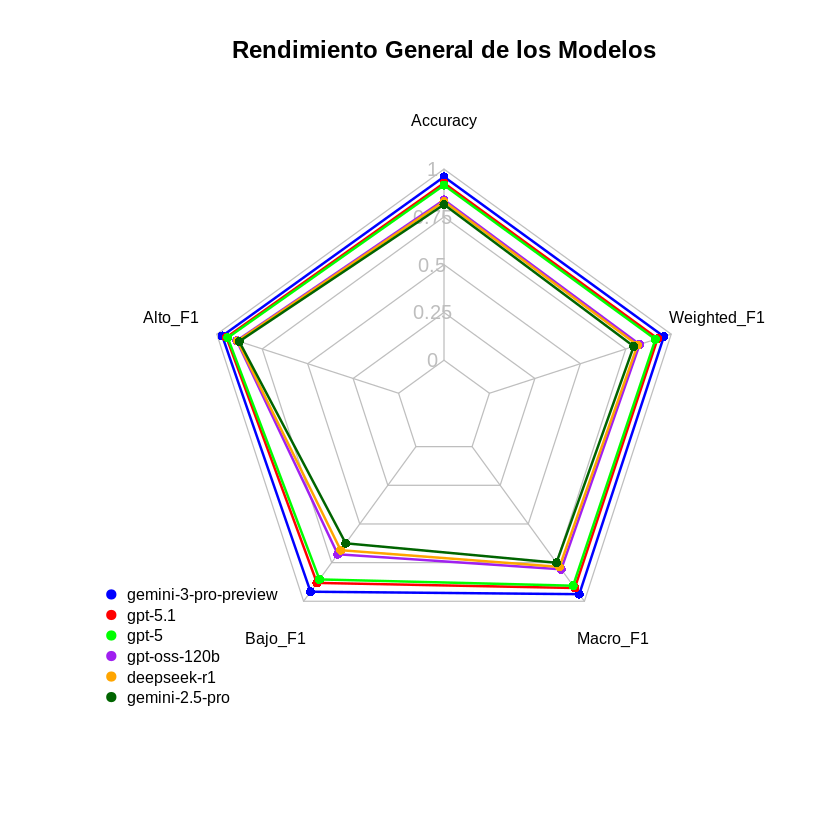

In [ ]:
library(dplyr)
library(tidyr)
library(fmsb) # Ensure fmsb is loaded for radarchart

# 1. Get accuracy_mean
df_accuracy <- all_model_stats$accuracy %>%
  select(model_name, accuracy_mean)

# 2. Get alto_f1_score_mean
df_alto_f1 <- all_model_stats$alto %>%
  select(model_name, alto_f1_score_mean)

# 3. Get bajo_f1_score_mean
df_bajo_f1 <- all_model_stats$bajo %>%
  select(model_name, bajo_f1_score_mean)

# 4. Get macro_avg_f1_score_mean
df_macro_f1 <- all_model_stats$macro_avg %>%
  select(model_name, macro_avg_f1_score_mean)

# 5. Get weighted_avg_f1_score_mean
df_weighted_f1 <- all_model_stats$weighted_avg %>%
  select(model_name, weighted_avg_f1_score_mean)

# Combine all into one dataframe
radar_data_all_metrics <- df_accuracy %>%
  left_join(df_alto_f1, by = "model_name") %>%
  left_join(df_bajo_f1, by = "model_name") %>%
  left_join(df_macro_f1, by = "model_name") %>%
  left_join(df_weighted_f1, by = "model_name")

# Rename columns for better readability in the plot
radar_data_all_metrics <- radar_data_all_metrics %>%
  rename(
    Accuracy = accuracy_mean,
    Alto_F1 = alto_f1_score_mean,
    Bajo_F1 = bajo_f1_score_mean,
    Macro_F1 = macro_avg_f1_score_mean,
    Weighted_F1 = weighted_avg_f1_score_mean
  )

# Sort radar_data_all_metrics by Accuracy so plot lines are drawn in this order
radar_data_all_metrics_sorted <- radar_data_all_metrics %>%
  arrange(desc(Accuracy))

# Prepare the data frame for radarchart: it needs max and min values as the first two rows
max_min_values_all <- data.frame(
  model_name = c("max", "min"),
  Accuracy = c(1, 0),
  Alto_F1 = c(1, 0),
  Bajo_F1 = c(1, 0),
  Macro_F1 = c(1, 0),
  Weighted_F1 = c(1, 0)
)

# Combine max/min with the actual model data (now sorted by Accuracy)
radar_chart_data_all <- rbind(max_min_values_all, radar_data_all_metrics_sorted)

# Convert to a matrix for radarchart, excluding the model_name column
radar_chart_matrix_all <- as.data.frame(radar_chart_data_all[, -1])

# Set colors and line types for each model
# Assuming up to 6 models, you can extend this if needed
colors_border_all <- c("blue", "red", "green", "purple", "orange", "darkgreen")
# colors_in_all_leg is now derived from colors_border_all, which will match the plot lines
colors_in_all_leg <- scales::alpha(colors_border_all, 0.9)

# Create the radar chart
radar_plot <- radarchart(
  radar_chart_matrix_all,
  axistype = 1,
  # Customize plot
  pcol = colors_border_all, # Colors will now be applied to the sorted models
  # pfcol = colors_in_all,
  plwd = 2,
  plty = 1,
  cglcol = "grey",
  cglty = 1,
  axislabcol = "grey",
  vlcex = 0.8,
  # Add custom axis labels
  caxislabels = c(0, 0.25, 0.5, 0.75, 1),
  # Title
  title = "Rendimiento General de los Modelos"
)

# The legend should use the model names from the sorted data frame
legend(
  x = "bottomleft",
  legend = radar_data_all_metrics_sorted$model_name, # Use sorted names for legend text
  bty = "n",
  pch = 20,
  col = colors_border_all, # Use the same color sequence as pcol in radarchart
  text.col = "black",
  cex = 0.8,
  pt.cex = 1.5
)

print(radar_plot)

In [ ]:
radar_chart_matrix_all

Accuracy,Alto_F1,Bajo_F1,Macro_F1,Weighted_F1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
0.9597561,0.9701422,0.9382671,0.9542046,0.9596467
0.9268293,0.9471190,0.8812445,0.9141818,0.9254286
0.9158537,0.9400567,0.8587295,0.8993931,0.9132782
0.8390244,0.8904787,0.6960323,0.7932555,0.8264537
0.8304878,0.8859804,0.6697283,0.7778544,0.8147755
0.8146341,0.8768525,0.6251626,0.7510075,0.7939790


In [ ]:
model_performance_metrics |> select(modelo, accuracy, sensitivity, specificity)

modelo,accuracy,sensitivity,specificity
<chr>,<dbl>,<dbl>,<dbl>
deepseek-r1,0.8292683,0.9818182,0.5185185
gemini-2.5-pro,0.8109756,0.9818182,0.4629630
gemini-3-pro-preview,0.9695122,0.9818182,0.9444444
gpt-5,0.9390244,0.9818182,0.8518519
gpt-5.1,0.9207317,0.9727273,0.8148148
gpt-oss-120b,0.8292683,0.9727273,0.5370370


In [ ]:
max_min_values_all <- data.frame(
  modelo = c("max", "min"),
  accuracy = c(1, 0),
  sensitivity = c(1, 0),
  specificity = c(1, 0)
)

# Combine max/min with the actual model data (now sorted by Accuracy)
radar_chart_data_all <- rbind(max_min_values_all, (model_performance_metrics |> select(modelo, accuracy, sensitivity, specificity)))

In [ ]:
radar_chart_data_all

modelo,accuracy,sensitivity,specificity
<chr>,<dbl>,<dbl>,<dbl>
max,1.0000000,1.0000000,1.0000000
min,0.0000000,0.0000000,0.0000000
deepseek-r1,0.8292683,0.9818182,0.5185185
gemini-2.5-pro,0.8109756,0.9818182,0.4629630
gemini-3-pro-preview,0.9695122,0.9818182,0.9444444
gpt-5,0.9390244,0.9818182,0.8518519
gpt-5.1,0.9207317,0.9727273,0.8148148
gpt-oss-120b,0.8292683,0.9727273,0.5370370


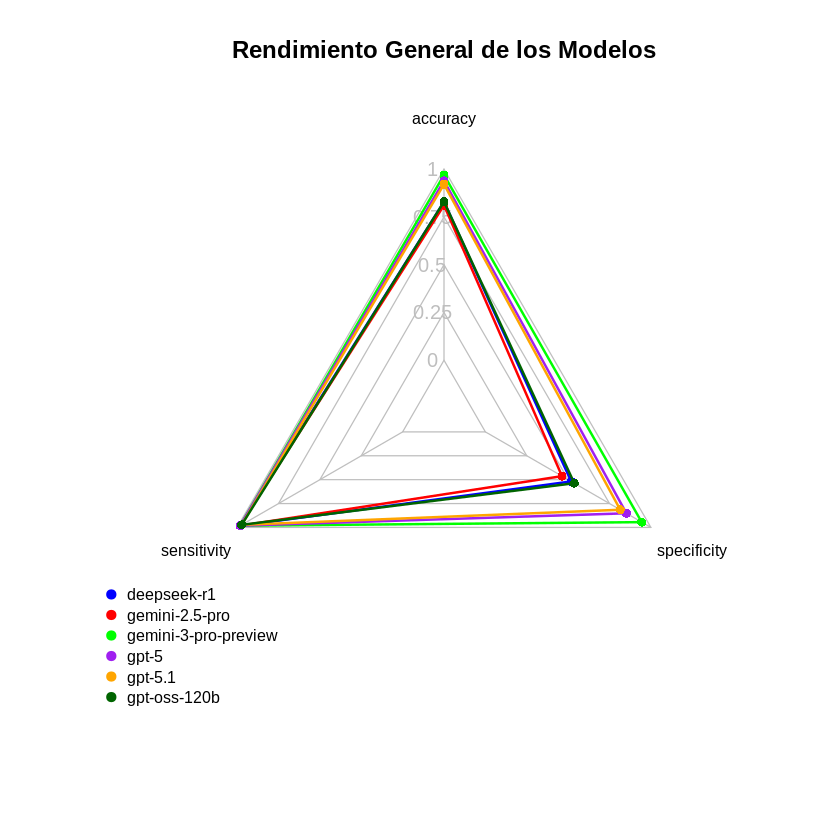

In [ ]:
library(fmsb)

# Select relevant columns and convert to a base data.frame explicitly
radar_metrics_data_df <- as.data.frame(model_performance_metrics %>%
  select(modelo, accuracy, sensitivity, specificity))

# Prepare the data frame for radarchart: it needs max and min values as the first two rows
max_min_values <- data.frame(
  modelo = c("max", "min"),
  accuracy = c(1, 0),
  sensitivity = c(1, 0),
  specificity = c(1, 0)
)

# Combine max/min with the actual model data
# Both max_min_values and radar_metrics_data_df are now explicit data.frames
radar_chart_data_temp <- rbind(max_min_values, radar_metrics_data_df)

# Set row names explicitly using the 'modelo' column
rownames(radar_chart_data_temp) <- radar_chart_data_temp$modelo

# Create the matrix for radarchart, excluding the modelo column
# This is already a data.frame with proper rownames
radar_chart_matrix <- radar_chart_data_temp[, -1]

# Define the number of models to plot for color allocation
num_models_in_plot <- nrow(radar_metrics_data_df) # Use the count of actual models
colors_border_all_plot <- c("blue", "red", "green", "purple", "orange", "darkgreen")[1:num_models_in_plot]
colors_in_all_leg_plot <- scales::alpha(colors_border_all_plot, 0)

radarchart(
  radar_chart_matrix,
  axistype = 1,
  # Customize plot
  pcol = colors_border_all_plot,
  pfcol = colors_in_all_leg_plot,
  plwd = 2,
  plty = 1,
  cglcol = "grey",
  cglty = 1,
  axislabcol = "grey",
  vlcex = 0.8,
  # Add custom axis labels
  caxislabels = c(0, 0.25, 0.5, 0.75, 1),
  # Title
  title = "Rendimiento General de los Modelos"
)

# Add a legend
legend(
  x = "bottomleft",
  legend = radar_metrics_data_df$modelo, # Use model names from the data used for actual plotting
  bty = "n",
  pch = 20,
  col = colors_border_all_plot, # Use the same color sequence as pcol in radarchart
  text.col = "black",
  cex = 0.8,
  pt.cex = 1.5
)

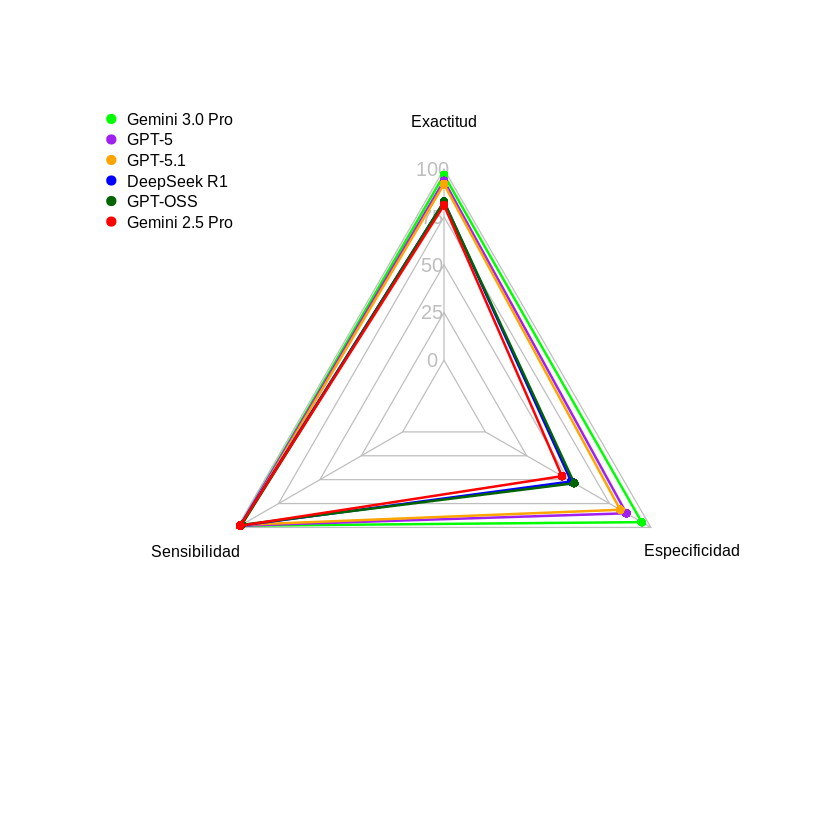

In [ ]:
library(fmsb) # Ensure fmsb is loaded as it is used here.

# Define model name mapping
model_name_mapping <- c(
  "deepseek-r1" = "DeepSeek R1",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gemini-3-pro-preview" = "Gemini 3.0 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "gpt-oss-120b" = "GPT-OSS"
)

# Define a fixed color palette for each displayed model name
# Ensure the number of colors matches the number of models
fixed_model_colors <- c(
  "DeepSeek R1" = "blue",
  "Gemini 2.5 Pro" = "red",
  "Gemini 3.0 Pro" = "green",
  "GPT-5" = "purple",
  "GPT-5.1" = "orange",
  "GPT-OSS" = "darkgreen"
)

# 1. Redefine radar_metrics_data_df and sort it by accuracy
radar_metrics_data_df <- as.data.frame(model_performance_metrics %>%
  select(modelo, accuracy, sensitivity, specificity) %>%
  arrange(desc(accuracy))) # Sort by accuracy

# Scale data by 100 for 0-100 radar chart scale
radar_metrics_data_df <- radar_metrics_data_df %>%
  mutate(
    accuracy = accuracy * 100,
    sensitivity = sensitivity * 100,
    specificity = specificity * 100
  )

# Prepare the data frame for radarchart: it needs max and min values as the first two rows
max_min_values <- data.frame(
  modelo = c("max", "min"),
  Exactitud = c(100, 0), # Changed to Spanish and scaled to 100
  Sensibilidad = c(100, 0), # Changed to Spanish and scaled to 100
  Especificidad = c(100, 0) # Changed to Spanish and scaled to 100
)

# Rename the columns in radar_metrics_data_df to match the Spanish labels for the radar chart
radar_metrics_data_df <- radar_metrics_data_df %>%
  rename(
    Exactitud = accuracy,
    Sensibilidad = sensitivity,
    Especificidad = specificity
  )

# Combine max/min with the actual model data (now sorted by accuracy)
radar_chart_data_temp <- rbind(max_min_values, radar_metrics_data_df)

# Set row names explicitly using the 'modelo' column
rownames(radar_chart_data_temp) <- radar_chart_data_temp$modelo

# Create the matrix for radarchart, excluding the modelo column
radar_chart_matrix <- radar_chart_data_temp[, -1]

# 5. Create ordered_display_names using the sorted radar_metrics_data_df and mapping
ordered_display_names <- recode(radar_metrics_data_df$modelo, !!!model_name_mapping)

# Now, retrieve the colors for the border in the order of ordered_display_names
# This ensures that each model gets its assigned fixed color, and these colors are
# then ordered according to the sorted models.
colors_border_all_plot <- fixed_model_colors[ordered_display_names]
colors_in_all_leg_plot <- scales::alpha(colors_border_all_plot, 0) # Using 0.3 transparency for fill


# Call radarchart with the newly sorted radar_chart_matrix and colors_border_all_plot
radarchart(
  radar_chart_matrix,
  axistype = 1,
  # Customize plot
  pcol = colors_border_all_plot, # Use the colors in the new sorted order
  pfcol = colors_in_all_leg_plot, # Also update fill colors
  plwd = 2,
  plty = 1,
  cglcol = "grey",
  cglty = 1,
  axislabcol = "grey",
  vlcex = 0.8,
  # Add custom axis labels
  caxislabels = c(0, 25, 50, 75, 100), # Scaled to 0-100
  # Title
  title = "" # Removed title
)

# Add a legend
legend(
  x = "topleft", # Moved legend to topleft
  legend = ordered_display_names, # Use the ordered display names
  bty = "n",
  pch = 20,
  col = colors_border_all_plot, # Use the same sorted colors for the legend
  text.col = "black",
  cex = 0.8,
  pt.cex = 1.5
)

In [ ]:
jpeg("radar_plot.jpg", width = 15, height = 15, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
radarchart(
  radar_chart_matrix,
  axistype = 1,
  # Customize plot
  pcol = colors_border_all_plot, # Use the colors in the new sorted order
  pfcol = colors_in_all_leg_plot, # Also update fill colors
  plwd = 2,
  plty = 1,
  cglcol = "grey",
  cglty = 1,
  axislabcol = "grey",
  vlcex = 0.8,
  # Add custom axis labels
  caxislabels = c(0, 25, 50, 75, 100), # Scaled to 0-100
  # Title
  title = "" # Removed title
)

# Add a legend
legend(
  x = "topleft", # Moved legend to topleft
  legend = ordered_display_names, # Use the ordered display names
  bty = "n",
  pch = 20,
  col = colors_border_all_plot, # Use the same sorted colors for the legend
  text.col = "black",
  cex = 0.8,
  pt.cex = 1.5
)
dev.off()

agg_record_548788902 
                   2

# Task
Join the individual metric data frames (accuracy, alto F1, bajo F1, macro F1, weighted F1) into a single data frame based on `model_name` and display the head of the resulting data frame.

## Prepare the data for the combined table

### Subtask:
Join the individual metric data frames (accuracy, alto F1, bajo F1, macro F1, weighted F1) into a single data frame based on `model_name`.


Extract the `model_name`, `accuracy_mean`, and `accuracy_sd` from `all_model_stats$accuracy` to initialize the `combined_df`.



In [ ]:
combined_df <- all_model_stats$accuracy %>%
  select(model_name, accuracy_mean, accuracy_sd)

Extract the `model_name`, `alto_f1_score_mean`, and `alto_f1_score_sd` from `all_model_stats$alto` and perform a left join with `combined_df`, renaming the F1-score columns to `Alto_F1_Mean` and `Alto_F1_SD` to avoid conflicts.



In [ ]:
combined_df <- combined_df %>%
  left_join(all_model_stats$alto %>%
              select(model_name, alto_f1_score_mean, alto_f1_score_sd),
            by = "model_name") %>%
  rename(Alto_F1_Mean = alto_f1_score_mean, Alto_F1_SD = alto_f1_score_sd)

cat("Combined DataFrame after joining alto_f1_score:")
print(head(combined_df))

Combined DataFrame after joining alto_f1_score:# A tibble: 6 × 5
  model_name           accuracy_mean accuracy_sd Alto_F1_Mean Alto_F1_SD
  <chr>                        <dbl>       <dbl>        <dbl>      <dbl>
1 deepseek-r1                  0.830     0.00510        0.886    0.00304
2 gemini-2.5-pro               0.815     0.0102         0.877    0.00604
3 gemini-3-pro-preview         0.960     0.00334        0.970    0.00237
4 gpt-5                        0.916     0.0169         0.940    0.0113 
5 gpt-5.1                      0.927     0.00964        0.947    0.00670
6 gpt-oss-120b                 0.839     0.0200         0.890    0.0124 


Extract the `model_name`, `bajo_f1_score_mean`, and `bajo_f1_score_sd` from `all_model_stats$bajo` and perform a left join with `combined_df`, renaming the F1-score columns to `Bajo_F1_Mean` and `Bajo_F1_SD`.



In [ ]:
combined_df <- combined_df %>%
  left_join(all_model_stats$bajo %>%
              select(model_name, bajo_f1_score_mean, bajo_f1_score_sd),
            by = "model_name") %>%
  rename(Bajo_F1_Mean = bajo_f1_score_mean, Bajo_F1_SD = bajo_f1_score_sd)

cat("Combined DataFrame after joining bajo_f1_score:")
print(head(combined_df))

Combined DataFrame after joining bajo_f1_score:# A tibble: 6 × 7
  model_name      accuracy_mean accuracy_sd Alto_F1_Mean Alto_F1_SD Bajo_F1_Mean
  <chr>                   <dbl>       <dbl>        <dbl>      <dbl>        <dbl>
1 deepseek-r1             0.830     0.00510        0.886    0.00304        0.670
2 gemini-2.5-pro          0.815     0.0102         0.877    0.00604        0.625
3 gemini-3-pro-p…         0.960     0.00334        0.970    0.00237        0.938
4 gpt-5                   0.916     0.0169         0.940    0.0113         0.859
5 gpt-5.1                 0.927     0.00964        0.947    0.00670        0.881
6 gpt-oss-120b            0.839     0.0200         0.890    0.0124         0.696
# ℹ 1 more variable: Bajo_F1_SD <dbl>


Extract the `model_name`, `macro_avg_f1_score_mean`, and `macro_avg_f1_score_sd` from `all_model_stats$macro_avg` and perform a left join with `combined_df`, renaming the F1-score columns to `Macro_F1_Mean` and `Macro_F1_SD`.



In [ ]:
combined_df <- combined_df %>%
  left_join(all_model_stats$macro_avg %>%
              select(model_name, macro_avg_f1_score_mean, macro_avg_f1_score_sd),
            by = "model_name") %>%
  rename(Macro_F1_Mean = macro_avg_f1_score_mean, Macro_F1_SD = macro_avg_f1_score_sd)

cat("Combined DataFrame after joining macro_f1_score:")
print(head(combined_df))

Combined DataFrame after joining macro_f1_score:# A tibble: 6 × 9
  model_name      accuracy_mean accuracy_sd Alto_F1_Mean Alto_F1_SD Bajo_F1_Mean
  <chr>                   <dbl>       <dbl>        <dbl>      <dbl>        <dbl>
1 deepseek-r1             0.830     0.00510        0.886    0.00304        0.670
2 gemini-2.5-pro          0.815     0.0102         0.877    0.00604        0.625
3 gemini-3-pro-p…         0.960     0.00334        0.970    0.00237        0.938
4 gpt-5                   0.916     0.0169         0.940    0.0113         0.859
5 gpt-5.1                 0.927     0.00964        0.947    0.00670        0.881
6 gpt-oss-120b            0.839     0.0200         0.890    0.0124         0.696
# ℹ 3 more variables: Bajo_F1_SD <dbl>, Macro_F1_Mean <dbl>, Macro_F1_SD <dbl>


Extract the `model_name`, `weighted_avg_f1_score_mean`, and `weighted_avg_f1_score_sd` from `all_model_stats$weighted_avg` and perform a left join with `combined_df`, renaming the F1-score columns to `Weighted_F1_Mean` and `Weighted_F1_SD`. This completes the joining of all F1-score related metrics.



In [ ]:
combined_df <- combined_df %>%
  left_join(all_model_stats$weighted_avg %>%
              select(model_name, weighted_avg_f1_score_mean, weighted_avg_f1_score_sd),
            by = "model_name") %>%
  rename(Weighted_F1_Mean = weighted_avg_f1_score_mean, Weighted_F1_SD = weighted_avg_f1_score_sd)

cat("Combined DataFrame after joining weighted_f1_score:")
print(head(combined_df))

Combined DataFrame after joining weighted_f1_score:# A tibble: 6 × 11
  model_name      accuracy_mean accuracy_sd Alto_F1_Mean Alto_F1_SD Bajo_F1_Mean
  <chr>                   <dbl>       <dbl>        <dbl>      <dbl>        <dbl>
1 deepseek-r1             0.830     0.00510        0.886    0.00304        0.670
2 gemini-2.5-pro          0.815     0.0102         0.877    0.00604        0.625
3 gemini-3-pro-p…         0.960     0.00334        0.970    0.00237        0.938
4 gpt-5                   0.916     0.0169         0.940    0.0113         0.859
5 gpt-5.1                 0.927     0.00964        0.947    0.00670        0.881
6 gpt-oss-120b            0.839     0.0200         0.890    0.0124         0.696
# ℹ 5 more variables: Bajo_F1_SD <dbl>, Macro_F1_Mean <dbl>, Macro_F1_SD <dbl>,
#   Weighted_F1_Mean <dbl>, Weighted_F1_SD <dbl>


## Format the mean and standard deviation

### Subtask:
For each required metric (Accuracy, Alto_F1, Bajo_F1, Macro_F1, Weighted_F1), create a formatted string column combining the mean and standard deviation in the 'Media ± DE' format.


Create formatted string columns for 'Accuracy' in the 'Mean (± SD)' format, rounded to three decimal places, by combining the `accuracy_mean` and `accuracy_sd` columns in `combined_df`. Use `sprintf` for formatting the values.



In [ ]:
combined_df <- combined_df %>%
  mutate(
    Accuracy_Formatted = sprintf("%.3f (\u00b1 %.3f)", accuracy_mean, accuracy_sd)
  )

cat("Combined DataFrame after formatting Accuracy:")
print(head(combined_df))

Combined DataFrame after formatting Accuracy:# A tibble: 6 × 12
  model_name      accuracy_mean accuracy_sd Alto_F1_Mean Alto_F1_SD Bajo_F1_Mean
  <chr>                   <dbl>       <dbl>        <dbl>      <dbl>        <dbl>
1 deepseek-r1             0.830     0.00510        0.886    0.00304        0.670
2 gemini-2.5-pro          0.815     0.0102         0.877    0.00604        0.625
3 gemini-3-pro-p…         0.960     0.00334        0.970    0.00237        0.938
4 gpt-5                   0.916     0.0169         0.940    0.0113         0.859
5 gpt-5.1                 0.927     0.00964        0.947    0.00670        0.881
6 gpt-oss-120b            0.839     0.0200         0.890    0.0124         0.696
# ℹ 6 more variables: Bajo_F1_SD <dbl>, Macro_F1_Mean <dbl>, Macro_F1_SD <dbl>,
#   Weighted_F1_Mean <dbl>, Weighted_F1_SD <dbl>, Accuracy_Formatted <chr>


Create formatted string columns for 'Alto_F1' in the 'Mean (± SD)' format, rounded to three decimal places, by combining the `Alto_F1_Mean` and `Alto_F1_SD` columns in `combined_df`.



In [ ]:
combined_df <- combined_df %>%
  mutate(
    Alto_F1_Formatted = sprintf("%.3f (\u00b1 %.3f)", Alto_F1_Mean, Alto_F1_SD)
  )

cat("Combined DataFrame after formatting Alto_F1:")
print(head(combined_df))

Combined DataFrame after formatting Alto_F1:# A tibble: 6 × 13
  model_name      accuracy_mean accuracy_sd Alto_F1_Mean Alto_F1_SD Bajo_F1_Mean
  <chr>                   <dbl>       <dbl>        <dbl>      <dbl>        <dbl>
1 deepseek-r1             0.830     0.00510        0.886    0.00304        0.670
2 gemini-2.5-pro          0.815     0.0102         0.877    0.00604        0.625
3 gemini-3-pro-p…         0.960     0.00334        0.970    0.00237        0.938
4 gpt-5                   0.916     0.0169         0.940    0.0113         0.859
5 gpt-5.1                 0.927     0.00964        0.947    0.00670        0.881
6 gpt-oss-120b            0.839     0.0200         0.890    0.0124         0.696
# ℹ 7 more variables: Bajo_F1_SD <dbl>, Macro_F1_Mean <dbl>, Macro_F1_SD <dbl>,
#   Weighted_F1_Mean <dbl>, Weighted_F1_SD <dbl>, Accuracy_Formatted <chr>,
#   Alto_F1_Formatted <chr>


Create formatted string columns for 'Bajo_F1' in the 'Mean (± SD)' format, rounded to three decimal places, by combining the `Bajo_F1_Mean` and `Bajo_F1_SD` columns in `combined_df`.



In [ ]:
combined_df <- combined_df %>%
  mutate(
    Bajo_F1_Formatted = sprintf("%.3f (\u00b1 %.3f)", Bajo_F1_Mean, Bajo_F1_SD)
  )

cat("Combined DataFrame after formatting Bajo_F1:")
print(head(combined_df))

Combined DataFrame after formatting Bajo_F1:# A tibble: 6 × 14
  model_name      accuracy_mean accuracy_sd Alto_F1_Mean Alto_F1_SD Bajo_F1_Mean
  <chr>                   <dbl>       <dbl>        <dbl>      <dbl>        <dbl>
1 deepseek-r1             0.830     0.00510        0.886    0.00304        0.670
2 gemini-2.5-pro          0.815     0.0102         0.877    0.00604        0.625
3 gemini-3-pro-p…         0.960     0.00334        0.970    0.00237        0.938
4 gpt-5                   0.916     0.0169         0.940    0.0113         0.859
5 gpt-5.1                 0.927     0.00964        0.947    0.00670        0.881
6 gpt-oss-120b            0.839     0.0200         0.890    0.0124         0.696
# ℹ 8 more variables: Bajo_F1_SD <dbl>, Macro_F1_Mean <dbl>, Macro_F1_SD <dbl>,
#   Weighted_F1_Mean <dbl>, Weighted_F1_SD <dbl>, Accuracy_Formatted <chr>,
#   Alto_F1_Formatted <chr>, Bajo_F1_Formatted <chr>


Create formatted string columns for 'Macro_F1' in the 'Mean (± SD)' format, rounded to three decimal places, by combining the `Macro_F1_Mean` and `Macro_F1_SD` columns in `combined_df`.



In [ ]:
combined_df <- combined_df %>%
  mutate(
    Macro_F1_Formatted = sprintf("%.3f (\u00b1 %.3f)", Macro_F1_Mean, Macro_F1_SD)
  )

cat("Combined DataFrame after formatting Macro_F1:")
print(head(combined_df))

Combined DataFrame after formatting Macro_F1:# A tibble: 6 × 15
  model_name      accuracy_mean accuracy_sd Alto_F1_Mean Alto_F1_SD Bajo_F1_Mean
  <chr>                   <dbl>       <dbl>        <dbl>      <dbl>        <dbl>
1 deepseek-r1             0.830     0.00510        0.886    0.00304        0.670
2 gemini-2.5-pro          0.815     0.0102         0.877    0.00604        0.625
3 gemini-3-pro-p…         0.960     0.00334        0.970    0.00237        0.938
4 gpt-5                   0.916     0.0169         0.940    0.0113         0.859
5 gpt-5.1                 0.927     0.00964        0.947    0.00670        0.881
6 gpt-oss-120b            0.839     0.0200         0.890    0.0124         0.696
# ℹ 9 more variables: Bajo_F1_SD <dbl>, Macro_F1_Mean <dbl>, Macro_F1_SD <dbl>,
#   Weighted_F1_Mean <dbl>, Weighted_F1_SD <dbl>, Accuracy_Formatted <chr>,
#   Alto_F1_Formatted <chr>, Bajo_F1_Formatted <chr>, Macro_F1_Formatted <chr>


Create formatted string columns for 'Weighted_F1' in the 'Mean (± SD)' format, rounded to three decimal places, by combining the `Weighted_F1_Mean` and `Weighted_F1_SD` columns in `combined_df`. This completes the formatting for all specified metrics.



In [ ]:
combined_df <- combined_df %>%
  mutate(
    Weighted_F1_Formatted = sprintf("%.3f (\u00b1 %.3f)", Weighted_F1_Mean, Weighted_F1_SD)
  )

cat("Combined DataFrame after formatting Weighted_F1:")
print(head(combined_df))

Combined DataFrame after formatting Weighted_F1:# A tibble: 6 × 16
  model_name      accuracy_mean accuracy_sd Alto_F1_Mean Alto_F1_SD Bajo_F1_Mean
  <chr>                   <dbl>       <dbl>        <dbl>      <dbl>        <dbl>
1 deepseek-r1             0.830     0.00510        0.886    0.00304        0.670
2 gemini-2.5-pro          0.815     0.0102         0.877    0.00604        0.625
3 gemini-3-pro-p…         0.960     0.00334        0.970    0.00237        0.938
4 gpt-5                   0.916     0.0169         0.940    0.0113         0.859
5 gpt-5.1                 0.927     0.00964        0.947    0.00670        0.881
6 gpt-oss-120b            0.839     0.0200         0.890    0.0124         0.696
# ℹ 10 more variables: Bajo_F1_SD <dbl>, Macro_F1_Mean <dbl>,
#   Macro_F1_SD <dbl>, Weighted_F1_Mean <dbl>, Weighted_F1_SD <dbl>,
#   Accuracy_Formatted <chr>, Alto_F1_Formatted <chr>, Bajo_F1_Formatted <chr>,
#   Macro_F1_Formatted <chr>, Weighted_F1_Formatted <chr>


Display the `model_name` and all the newly created formatted metric columns to show the final result of the subtask.



In [ ]:
final_combined_df <- combined_df %>%
  select(model_name, Accuracy_Formatted, Alto_F1_Formatted, Bajo_F1_Formatted, Macro_F1_Formatted, Weighted_F1_Formatted)

cat("\nFinal Combined DataFrame with Formatted Metrics:\n")
print(final_combined_df)


Final Combined DataFrame with Formatted Metrics:
# A tibble: 6 × 6
  model_name           Accuracy_Formatted Alto_F1_Formatted Bajo_F1_Formatted
  <chr>                <chr>              <chr>             <chr>            
1 deepseek-r1          0.830 (± 0.005)    0.886 (± 0.003)   0.670 (± 0.013)  
2 gemini-2.5-pro       0.815 (± 0.010)    0.877 (± 0.006)   0.625 (± 0.028)  
3 gemini-3-pro-preview 0.960 (± 0.003)    0.970 (± 0.002)   0.938 (± 0.006)  
4 gpt-5                0.916 (± 0.017)    0.940 (± 0.011)   0.859 (± 0.033)  
5 gpt-5.1              0.927 (± 0.010)    0.947 (± 0.007)   0.881 (± 0.017)  
6 gpt-oss-120b         0.839 (± 0.020)    0.890 (± 0.012)   0.696 (± 0.047)  
# ℹ 2 more variables: Macro_F1_Formatted <chr>, Weighted_F1_Formatted <chr>


## Rename and order the columns

### Subtask:
Rename the `model_name` column to `Modelo` and sort the data frame by `Weighted_F1` (mean) in descending order, then select the final set of columns for the table.


Rename the 'model_name' column to 'Modelo', sort the DataFrame by 'Weighted_F1_Mean' in descending order, and then select the specified formatted columns to prepare the final table.



In [ ]:
final_combined_df <- combined_df %>%
  rename(Modelo = model_name) %>%
  arrange(desc(Weighted_F1_Mean)) %>%
  select(Modelo, Accuracy_Formatted, Alto_F1_Formatted, Bajo_F1_Formatted, Macro_F1_Formatted, Weighted_F1_Formatted)

cat("\nFinal Combined DataFrame after renaming, sorting, and selecting columns:\n")
print(final_combined_df)


Final Combined DataFrame after renaming, sorting, and selecting columns:
# A tibble: 6 × 6
  Modelo               Accuracy_Formatted Alto_F1_Formatted Bajo_F1_Formatted
  <chr>                <chr>              <chr>             <chr>            
1 gemini-3-pro-preview 0.960 (± 0.003)    0.970 (± 0.002)   0.938 (± 0.006)  
2 gpt-5.1              0.927 (± 0.010)    0.947 (± 0.007)   0.881 (± 0.017)  
3 gpt-5                0.916 (± 0.017)    0.940 (± 0.011)   0.859 (± 0.033)  
4 gpt-oss-120b         0.839 (± 0.020)    0.890 (± 0.012)   0.696 (± 0.047)  
5 deepseek-r1          0.830 (± 0.005)    0.886 (± 0.003)   0.670 (± 0.013)  
6 gemini-2.5-pro       0.815 (± 0.010)    0.877 (± 0.006)   0.625 (± 0.028)  
# ℹ 2 more variables: Macro_F1_Formatted <chr>, Weighted_F1_Formatted <chr>


In [ ]:
write.csv(final_combined_df, "model_performance_summary.csv", row.names = FALSE)
cat("final_combined_df exported to model_performance_summary.csv")

final_combined_df exported to model_performance_summary.csv

In [ ]:
radar_chart_data_all

modelo,accuracy,sensitivity,specificity
<chr>,<dbl>,<dbl>,<dbl>
max,1.0000000,1.0000000,1.0000000
min,0.0000000,0.0000000,0.0000000
deepseek-r1,0.8292683,0.9818182,0.5185185
gemini-2.5-pro,0.8109756,0.9818182,0.4629630
gemini-3-pro-preview,0.9695122,0.9818182,0.9444444
gpt-5,0.9390244,0.9818182,0.8518519
gpt-5.1,0.9207317,0.9727273,0.8148148
gpt-oss-120b,0.8292683,0.9727273,0.5370370


In [ ]:
write.csv(radar_chart_data_all %>% mutate_if(is.numeric, round, digits = 2), "model_sensit_specifi.csv", row.names = FALSE)

In [ ]:
weighted_avg_metrics_df

model_name,weighted_avg_precision_mean,weighted_avg_precision_sd,weighted_avg_recall_mean,weighted_avg_recall_sd,weighted_avg_f1_score_mean,weighted_avg_f1_score_sd,weighted_avg_support_mean,weighted_avg_support_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
deepseek-r1,0.8488636,0.003989038,0.8304878,0.005101586,0.8147755,0.006403230,164,0
gemini-2.5-pro,0.8380803,0.009160174,0.8146341,0.010203171,0.7939790,0.013112102,164,0
gemini-3-pro-preview,0.9598480,0.003256698,0.9597561,0.003339772,0.9596467,0.003443924,164,0
gpt-5,0.9192431,0.014812861,0.9158537,0.016920045,0.9132782,0.018356947,164,0
gpt-5.1,0.9279901,0.009329175,0.9268293,0.009641090,0.9254286,0.010087704,164,0
gpt-oss-120b,0.8511593,0.017977352,0.8390244,0.020038630,0.8264537,0.023877644,164,0


In [ ]:
write.csv(weighted_avg_metrics_df %>% mutate_if(is.numeric, round, digits = 3), "weighted_avg_metrics.csv", row.names = FALSE)

In [ ]:
write.csv(model_performance_metrics, "model_performance_metrics.csv", row.names = FALSE)


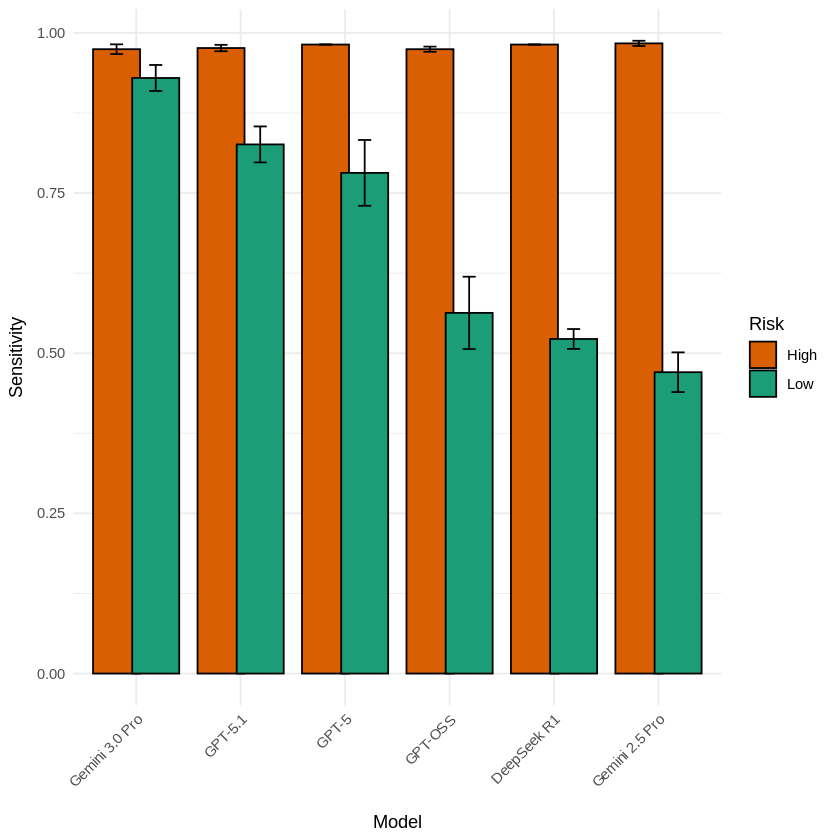

In [ ]:
# The 'model_name_mapping' is needed for display purposes. Redeclaring it here for self-containment.
model_name_mapping <- c(
  "gemini-3-pro-preview" = "Gemini 3.0 Pro",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "deepseek-r1" = "DeepSeek R1",
  "gpt-oss-120b" = "GPT-OSS"
)

# Create the sensitivity by class long format dataframe
sensitivity_by_class_long_df <- bind_rows(
  all_model_stats$alto %>%
    select(model_name, alto_recall_mean, alto_recall_sd) %>%
    rename(mean = alto_recall_mean, sd = alto_recall_sd) %>%
    mutate(class = "alto"),
  all_model_stats$bajo %>%
    select(model_name, bajo_recall_mean, bajo_recall_sd) %>%
    rename(mean = bajo_recall_mean, sd = bajo_recall_sd) %>%
    mutate(class = "bajo")
) %>%
  mutate(display_model_name = recode(model_name, !!!model_name_mapping))

# Determine the order of models based on 'bajo' sensitivity
ordered_models_by_bajo_sensitivity <- sensitivity_by_class_long_df %>%
  filter(class == "bajo") %>%
  arrange(desc(mean)) %>%
  pull(display_model_name)

# Generate the grouped bar plot for Sensitivity by Class
sensitivity_by_class_plot <- ggplot(sensitivity_by_class_long_df, aes(x = factor(display_model_name, levels = ordered_models_by_bajo_sensitivity), y = mean, fill = class)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.75), color = "black") +
  geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd), position = position_dodge(width = 0.75), width = 0.25) +
  labs(
    x = "Model",
    y = "Sensitivity",
    # title = "Sensibilidad por Clasificación de Riesgo",
    fill = "Risk" # Changed legend title to 'Risk'
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = c("alto" = "#D95F02", "bajo" = "#1B9E77"), # Changed to orange and green from Dark2 palette
                    labels = c("alto" = "High", "bajo" = "Low")) # Changed labels for 'alto' and 'bajo'

print(sensitivity_by_class_plot)

In [ ]:
jpeg("sensitivity_by_class_plot.jpg", width = 15, height = 10, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
print(sensitivity_by_class_plot)
dev.off()

agg_record_713180531 
                   2

In [ ]:
pdf("sensitivity_by_class_plot.pdf", width = 6, height = 4) # Adjust width and height as needed
print(sensitivity_by_class_plot)
dev.off()

agg_record_1177208984 
                    2

# Task
**Prepare Data for Plotting Confusion Matrices**: Reshape `model_performance_metrics` into a format suitable for plotting, specifically focusing on TP, TN, FP, FN for each model. This might involve pivoting the data or creating separate dataframes for each model.
**Generate Confusion Matrix Plots for Each Model**: For each model, create a visual representation of its confusion matrix. A heatmap or a custom-styled table might be suitable, or a bar chart of TP, TN, FP, FN.
**Summarize Confusion Matrix Plots**: Provide a summary of the generated confusion matrix plots, highlighting key findings and insights from each model's performance in terms of TP, TN, FP, and FN.

## Prepare Data for Plotting Confusion Matrices

### Subtask:
Reshape `model_performance_metrics` into a format suitable for plotting, specifically focusing on TP, TN, FP, FN for each model. This might involve pivoting the data or creating separate dataframes for each model.


Select the specified columns from `model_performance_metrics`, then pivot them into a long format with `metric_type` and `count` columns, storing the result in `confusion_matrix_long_df`, and finally print its head and structure to verify the transformation.



In [ ]:
confusion_matrix_long_df <- model_performance_metrics %>%
  select(modelo, TP, TN, FP, FN) %>%
  pivot_longer(
    cols = c(TP, TN, FP, FN),
    names_to = "metric_type",
    values_to = "count"
  )

cat("\nHead of confusion_matrix_long_df:\n")
print(head(confusion_matrix_long_df))

cat("\nStructure of confusion_matrix_long_df:\n")
str(confusion_matrix_long_df)


Head of confusion_matrix_long_df:
# A tibble: 6 × 3
  modelo         metric_type count
  <chr>          <chr>       <int>
1 deepseek-r1    TP            108
2 deepseek-r1    TN             28
3 deepseek-r1    FP             26
4 deepseek-r1    FN              2
5 gemini-2.5-pro TP            108
6 gemini-2.5-pro TN             25

Structure of confusion_matrix_long_df:
tibble [24 × 3] (S3: tbl_df/tbl/data.frame)
 $ modelo     : chr [1:24] "deepseek-r1" "deepseek-r1" "deepseek-r1" "deepseek-r1" ...
 $ metric_type: chr [1:24] "TP" "TN" "FP" "FN" ...
 $ count      : int [1:24] 108 28 26 2 108 25 29 2 108 51 ...


## Generate Confusion Matrix Plots for Each Model

### Subtask:
For each model, create a visual representation of its confusion matrix. A heatmap or a custom-styled table might be suitable, or a bar chart of TP, TN, FP, FN.


Define the model name mapping and then create a facetted bar plot using `confusion_matrix_long_df` to visualize the TP, TN, FP, and FN counts for each model, as specified in the instructions. This will provide a clear visual representation of each model's confusion matrix.



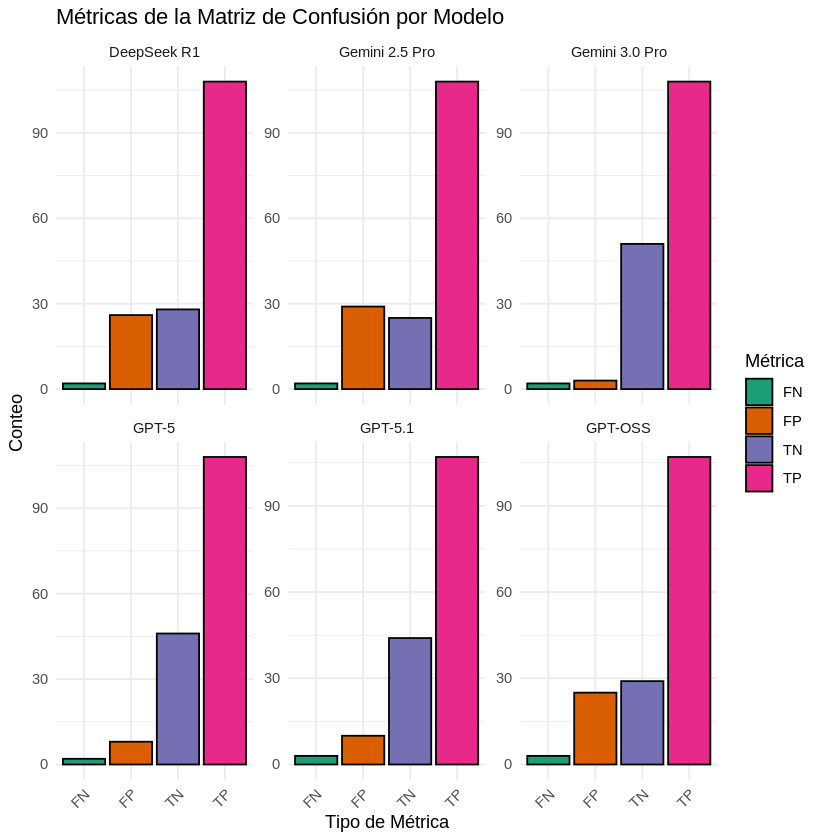

In [ ]:
model_name_mapping <- c(
  "gemini-3-pro-preview" = "Gemini 3.0 Pro",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "deepseek-r1" = "DeepSeek R1",
  "gpt-oss-120b" = "GPT-OSS"
)

confusion_matrix_long_df_display <- confusion_matrix_long_df %>%
  mutate(display_model_name = recode(modelo, !!!model_name_mapping))

confusion_matrix_plot <- ggplot(confusion_matrix_long_df_display, aes(x = metric_type, y = count, fill = metric_type)) +
  geom_bar(stat = "identity", color = "black") +
  facet_wrap(~ display_model_name, scales = "free_y") + # Facet by model_name
  labs(
    x = "Tipo de Métrica",
    y = "Conteo",
    title = "Métricas de la Matriz de Confusión por Modelo",
    fill = "Métrica"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + # Adjust x-axis text
  scale_fill_brewer(palette = "Dark2") # Use a color palette

print(confusion_matrix_plot)

Save the generated `confusion_matrix_plot` to a JPEG file, following the pattern of saving plots to disk for reproducibility and easy sharing.



In [ ]:
jpeg("confusion_matrix_plot.jpg", width = 20, height = 15, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
print(confusion_matrix_plot)
dev.off()


agg_record_1896847569 
                    2

# Task
Create a heatmap visualization for the confusion matrix of each model using the `confusion_matrix_long_df` data. Each heatmap will display True Positives, True Negatives, False Positives, and False Negatives, with models presented in separate facets.

## Generate Confusion Matrix Heatmap for Each Model

### Subtask:
For each model, create a heatmap visualization of its confusion matrix using the prepared `confusion_matrix_long_df`. This will involve using `geom_tile` for the heatmap and `geom_text` for value labels, with appropriate aesthetic mappings.


Create a heatmap visualization of the confusion matrix for each model, using the `confusion_matrix_long_df_display` DataFrame. This involves mapping `metric_type` and `display_model_name` to the axes and `count` to the fill color, then adding `geom_tile` for the heatmap and `geom_text` for value labels, as well as faceting by model and setting appropriate titles and color scales.



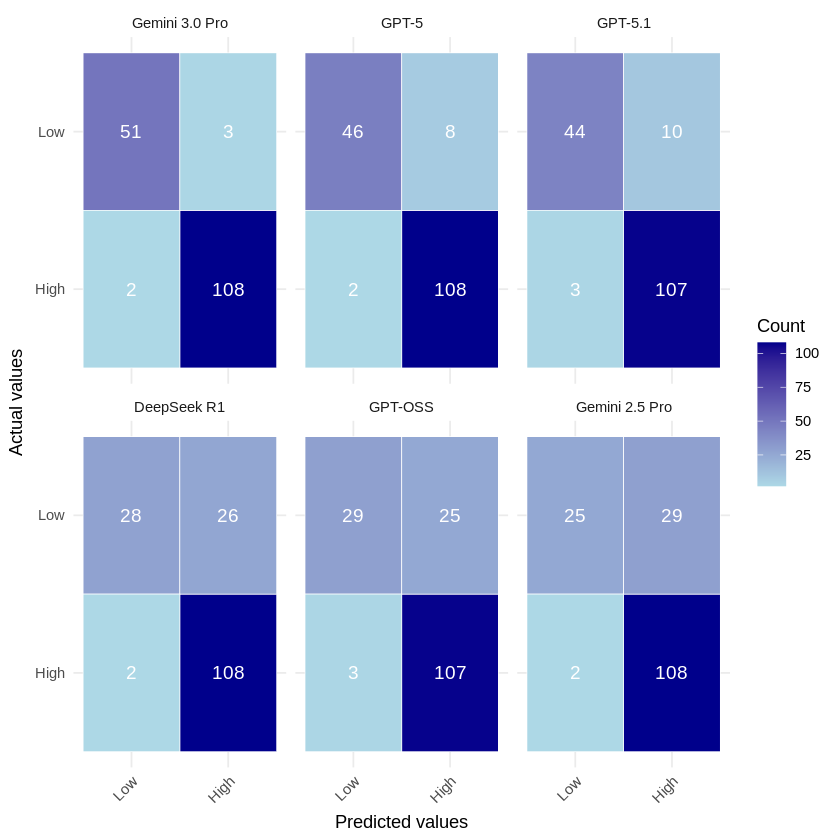

In [ ]:
model_name_mapping <- c(
  "gemini-3-pro-preview" = "Gemini 3.0 Pro",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "deepseek-r1" = "DeepSeek R1",
  "gpt-oss-120b" = "GPT-OSS"
)

# Get the order of models based on accuracy
model_order_by_accuracy <- model_performance_metrics %>%
  arrange(desc(accuracy)) %>%
  pull(modelo)

confusion_matrix_long_df_display <- confusion_matrix_long_df %>%
  mutate(display_model_name = recode(modelo, !!!model_name_mapping)) %>%
  # Reorder display_model_name based on accuracy
  mutate(display_model_name = factor(display_model_name, levels = recode(model_order_by_accuracy, !!!model_name_mapping))) %>%
  # Add Actual and Predicted columns for the 2x2 matrix
  mutate(
    Actual = case_when(
      metric_type == "TP" ~ "High",
      metric_type == "FN" ~ "High",
      metric_type == "TN" ~ "Low",
      metric_type == "FP" ~ "Low"
    ),
    Predicted = case_when(
      metric_type == "TP" ~ "High",
      metric_type == "FP" ~ "High",
      metric_type == "TN" ~ "Low",
      metric_type == "FN" ~ "Low"
    )
  ) %>%
  # Ensure proper order for plotting
  mutate(
    Actual = factor(Actual, levels = c("High", "Low")),
    Predicted = factor(Predicted, levels = c("Low", "High"))
  )

# Create the heatmap plot
confusion_matrix_heatmap_plot <- ggplot(confusion_matrix_long_df_display, aes(x = Predicted, y = Actual, fill = count)) +
  geom_tile(color = "white") + # Add white borders to tiles
  geom_text(aes(label = count), color = "white", size = 4) + # Increased size and changed color to white
  facet_wrap(~ display_model_name, nrow = 2, ncol = 3) + # Facet by model_name in a 2x3 grid
  labs(
    x = "Predicted values",
    y = "Actual values",
    #title = "Matrices de Confusión por Modelo",
    fill = "Count"
  ) +
  scale_fill_gradient(low = "lightblue", high = "darkblue") + # Use a blue continuous color scale
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(hjust = 0.5) # Center plot title
  )

print(confusion_matrix_heatmap_plot)

Save the generated `confusion_matrix_heatmap_plot` to a JPEG file, following the pattern of saving plots to disk for reproducibility and easy sharing.



In [ ]:
jpeg("confusion_matrix_heatmap_plot.jpg", width = 15, height = 10, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
print(confusion_matrix_heatmap_plot)
dev.off()


agg_record_555636739 
                   2

# Task
Calculate metrics (TP, TN, FP, FN, accuracy, sensitivity, specificity) for each model (`modelo`) and for each prediction column ('0', '1', '2', '3', '4') in `unified_excel_df`, using 'Riesgo...15' as the reference and 'alto' as the positive class. Then, combine these results, calculate the mean of each metric across the five prediction columns for each model, and display the resulting data frame.

## Calculate Metrics per Prediction Column

### Subtask:
For each of the columns '0', '1', '2', '3', '4', group `unified_excel_df` by 'modelo', calculate the confusion matrix components (TP, TN, FP, FN) using 'Riesgo...15' as reference and the current prediction column as prediction (with 'alto' as the positive class). Then, apply the `calculate_metrics` function to derive accuracy, sensitivity, and specificity. Store these results for each prediction column.


Initialize an empty list, then loop through each prediction column, calculate the confusion matrix components, apply the `calculate_metrics` function, add a column to identify the prediction source, and store the results in the list as instructed. Finally, print the head of the first resulting dataframe.



In [ ]:
all_prediction_metrics <- list()

for (col_name in mode_cols) {
  cat(paste0("Calculating metrics for prediction column: ", col_name, "\n"))

  # Filter out NA values from the relevant columns
  filtered_df <- unified_excel_df %>%
    filter(!is.na(`Riesgo...15`), !is.na(.data[[col_name]]))

  # Calculate metrics for the current prediction column
  current_col_metrics <- filtered_df %>%
    group_by(modelo) %>%
    summarise(
      TP = sum(`Riesgo...15` == "alto" & .data[[col_name]] == "alto", na.rm = TRUE),
      TN = sum(`Riesgo...15` == "bajo" & .data[[col_name]] == "bajo", na.rm = TRUE),
      FP = sum(`Riesgo...15` == "bajo" & .data[[col_name]] == "alto", na.rm = TRUE),
      FN = sum(`Riesgo...15` == "alto" & .data[[col_name]] == "bajo", na.rm = TRUE)
    ) %>%
    rowwise() %>%
    mutate(
      metrics = list(calculate_metrics(c(TP = TP, TN = TN, FP = FP, FN = FN)))
    ) %>%
    ungroup() %>%
    unnest_wider(metrics) %>%
    mutate(prediction_column = col_name)

  all_prediction_metrics[[col_name]] <- current_col_metrics
}

cat("\nHead of metrics for the first prediction column ('0'):\n")
print(head(all_prediction_metrics[["0"]]))

Calculating metrics for prediction column: 0
Calculating metrics for prediction column: 1
Calculating metrics for prediction column: 2
Calculating metrics for prediction column: 3
Calculating metrics for prediction column: 4

Head of metrics for the first prediction column ('0'):
# A tibble: 6 × 9
  modelo                  TP    TN    FP    FN accuracy sensitivity specificity
  <chr>                <int> <int> <int> <int>    <dbl>       <dbl>       <dbl>
1 deepseek-r1            108    27    27     2    0.823       0.982       0.5  
2 gemini-2.5-pro         108    28    26     2    0.829       0.982       0.519
3 gemini-3-pro-preview   108    49     5     2    0.957       0.982       0.907
4 gpt-5                  108    41    13     2    0.909       0.982       0.759
5 gpt-5.1                107    47     7     3    0.939       0.973       0.870
6 gpt-oss-120b           108    33    21     2    0.860       0.982       0.611
# ℹ 1 more variable: prediction_column <chr>


Now that the metrics have been calculated for each prediction column, combine all these results into a single data frame using `bind_rows` and then group by `modelo` to calculate the mean of each metric across the five prediction columns. This will provide an overall average performance for each model.



In [ ]:
combined_all_prediction_metrics <- bind_rows(all_prediction_metrics)

# Calculate the mean of each metric across the five prediction columns for each model
mean_metrics_per_model <- combined_all_prediction_metrics %>%
  group_by(modelo) %>%
  summarise(
    mean_TP = mean(TP, na.rm = TRUE),
    mean_TN = mean(TN, na.rm = TRUE),
    mean_FP = mean(FP, na.rm = TRUE),
    mean_FN = mean(FN, na.rm = TRUE),
    mean_accuracy = mean(accuracy, na.rm = TRUE),
    mean_sensitivity = mean(sensitivity, na.rm = TRUE),
    mean_specificity = mean(specificity, na.rm = TRUE)
  )

cat("\nMean Metrics per Model (averaged across prediction columns):\n")
print(mean_metrics_per_model)



Mean Metrics per Model (averaged across prediction columns):
# A tibble: 6 × 8
  modelo          mean_TP mean_TN mean_FP mean_FN mean_accuracy mean_sensitivity
  <chr>             <dbl>   <dbl>   <dbl>   <dbl>         <dbl>            <dbl>
1 deepseek-r1        108     28.2    25.8     2           0.830            0.982
2 gemini-2.5-pro     108.    25.4    28.6     1.8         0.815            0.984
3 gemini-3-pro-p…    107.    50.2     3.8     2.8         0.960            0.975
4 gpt-5              108     42.2    11.8     2           0.916            0.982
5 gpt-5.1            107.    44.6     9.4     2.6         0.927            0.976
6 gpt-oss-120b       107.    30.4    23.6     2.8         0.839            0.975
# ℹ 1 more variable: mean_specificity <dbl>


In [ ]:
mean_metrics_per_model

modelo,mean_TP,mean_TN,mean_FP,mean_FN,mean_accuracy,mean_sensitivity,mean_specificity
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
deepseek-r1,108.0,28.2,25.8,2.0,0.8304878,0.9818182,0.5222222
gemini-2.5-pro,108.2,25.4,28.6,1.8,0.8146341,0.9836364,0.4703704
gemini-3-pro-preview,107.2,50.2,3.8,2.8,0.9597561,0.9745455,0.9296296
gpt-5,108.0,42.2,11.8,2.0,0.9158537,0.9818182,0.7814815
gpt-5.1,107.4,44.6,9.4,2.6,0.9268293,0.9763636,0.8259259
gpt-oss-120b,107.2,30.4,23.6,2.8,0.8390244,0.9745455,0.5629630


In [ ]:
round(mean_metrics_per_model[2:5], 0)

mean_TP,mean_TN,mean_FP,mean_FN
<dbl>,<dbl>,<dbl>,<dbl>
108,28,26,2
108,25,29,2
107,50,4,3
108,42,12,2
107,45,9,3
107,30,24,3


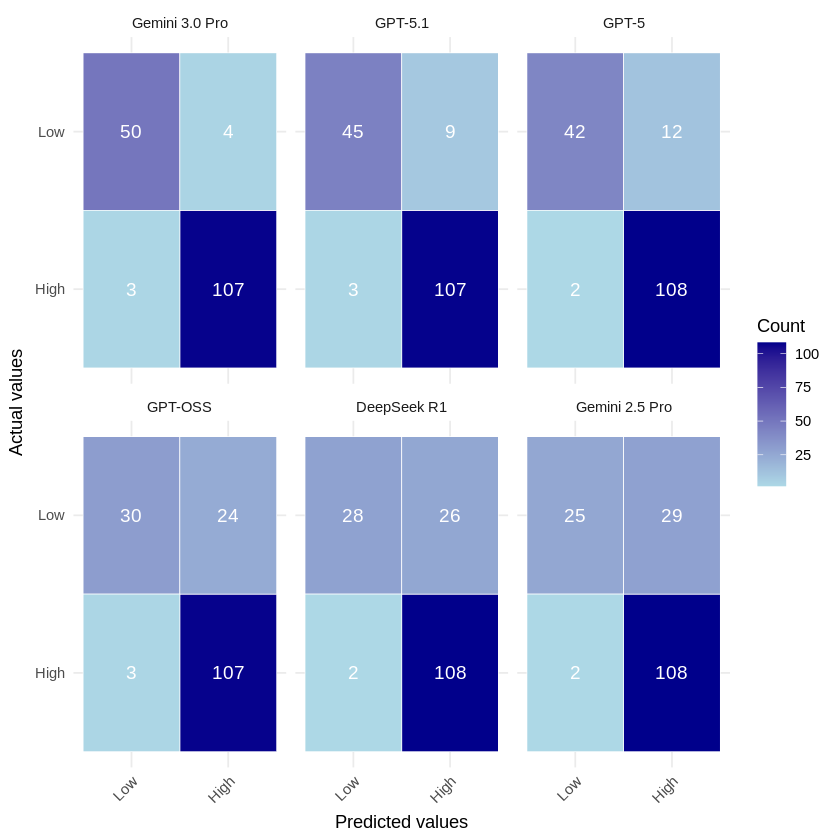

In [ ]:
model_name_mapping <- c(
  "gemini-3-pro-preview" = "Gemini 3.0 Pro",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "deepseek-r1" = "DeepSeek R1",
  "gpt-oss-120b" = "GPT-OSS"
)

# Get the order of models based on mean accuracy from mean_metrics_per_model
model_order_by_accuracy <- mean_metrics_per_model %>%
  arrange(desc(mean_accuracy)) %>%
  pull(modelo)

# Prepare data from mean_metrics_per_model for heatmap
mean_confusion_matrix_long_df_display <- mean_metrics_per_model %>%
  select(modelo, mean_TP, mean_TN, mean_FP, mean_FN) %>%
  pivot_longer(
    cols = c(mean_TP, mean_TN, mean_FP, mean_FN),
    names_to = "metric_type",
    values_to = "count"
  ) %>%
  mutate(display_model_name = recode(modelo, !!!model_name_mapping)) %>%
  # Reorder display_model_name based on accuracy
  mutate(display_model_name = factor(display_model_name, levels = recode(model_order_by_accuracy, !!!model_name_mapping))) %>%
  # Add Actual and Predicted columns for the 2x2 matrix
  mutate(
    Actual = case_when(
      metric_type == "mean_TP" ~ "High",
      metric_type == "mean_FN" ~ "High",
      metric_type == "mean_TN" ~ "Low",
      metric_type == "mean_FP" ~ "Low"
    ),
    Predicted = case_when(
      metric_type == "mean_TP" ~ "High",
      metric_type == "mean_FP" ~ "High",
      metric_type == "mean_TN" ~ "Low",
      metric_type == "mean_FN" ~ "Low"
    )
  ) %>%
  # Ensure proper order for plotting
  mutate(
    Actual = factor(Actual, levels = c("High", "Low")),
    Predicted = factor(Predicted, levels = c("Low", "High"))
  )

# Create the heatmap plot using averaged metrics
mean_confusion_matrix_heatmap_plot <- ggplot(mean_confusion_matrix_long_df_display, aes(x = Predicted, y = Actual, fill = count)) +
  geom_tile(color = "white") + # Add white borders to tiles
  geom_text(aes(label = round(count, 0)), color = "white", size = 4) + # Rounded counts for display
  facet_wrap(~ display_model_name, nrow = 2, ncol = 3) + # Facet by model_name in a 2x3 grid
  labs(
    x = "Predicted values",
    y = "Actual values",
    # title = "Matrices de Confusión Promedio por Modelo",
    fill = "Count"
  ) +
  scale_fill_gradient(low = "lightblue", high = "darkblue") + # Use a blue continuous color scale
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(hjust = 0.5) # Center plot title
  )

print(mean_confusion_matrix_heatmap_plot)

In [ ]:
jpeg("mean_confusion_matrix_heatmap_plot.jpg", width = 15, height = 10, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
print(mean_confusion_matrix_heatmap_plot)
dev.off()

agg_record_11699031 
                  2

In [ ]:
pdf("mean_confusion_matrix_heatmap_plot.pdf", width = 7, height = 5) # Adjust width and height as needed
print(mean_confusion_matrix_heatmap_plot)
dev.off()

agg_record_1728921657 
                    2

In [ ]:
head(unified_excel_df)

¿Vives en un área donde se administra fluoración comunitaria? (agua / sal / leche),¿El niño asiste regularmente al dentista (1 vez al año) para prevención/control?,¿Se cepillan los dientes del niño al menos 2 veces al día con una pasta dental que contenga ≥ 1000 ppm de fluoruro?,"Ahora, ¿crees que tienes caries o dolor dental?","¿Normalmente enfrentas barreras para acceder a los servicios de salud (financieras, transporte, disponibilidad de citas)?","La última vez que el niño asistió al dentista, ¿tuvo dolor dental, o ahora mismo, tiene dolor dental?","Si el niño tiene necesidades especiales (discapacidad física) para realizar la higiene bucal, ¿alguien más lo hace?","¿El niño consume más de 50 g de azúcares libres por día o consume cada noche bebidas con azúcares naturales o añadidos (en biberón/taza antidesbordamiento/vaso/taza) o chupete endulzado, incluyendo leche y jugos/smoothies de frutas?","¿Se le ha diagnosticado al niño hiposalivación (relacionada con medicamentos, enfermedad o radiación en cabeza y cuello)?",Presencia de hiposalivación,⋯,Presencia de mala higiene oral con acumulación de biopelícula dental espesa,Riesgo...14,Riesgo...15,0,1,2,3,4,modelo,moda
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0,0,0,1,0,0,1,0,0,1,⋯,1,HIGH,alto,alto,alto,alto,alto,alto,deepseek-r1,alto
0,1,0,1,1,1,0,1,1,1,⋯,0,HIGH,alto,alto,alto,alto,alto,alto,deepseek-r1,alto
1,1,1,1,0,0,1,1,1,0,⋯,1,HIGH,alto,alto,alto,alto,alto,alto,deepseek-r1,alto
1,0,1,0,0,0,1,0,1,1,⋯,0,HIGH,alto,alto,alto,alto,alto,alto,deepseek-r1,alto
0,1,0,0,0,0,1,1,0,0,⋯,0,HIGH,alto,alto,alto,alto,alto,alto,deepseek-r1,alto
1,0,1,1,0,0,0,0,1,0,⋯,0,HIGH,alto,alto,alto,alto,alto,alto,deepseek-r1,alto


# Task
Identify and rename the 13 input feature columns in `unified_excel_df` with shorter, more descriptive names for improved readability and analysis.

## Identify and Rename Input Features

### Subtask:
Identify the 13 input feature columns (representing questions/factors) from `unified_excel_df`. Rename these columns to simpler, more manageable names for easier analysis and reference in the subsequent steps.


Rename the first 13 columns of `unified_excel_df` to simpler, more manageable names using a named vector for mapping, as specified in the instructions. Then  display the head of the DataFrame to verify the changes.



In [ ]:
new_column_names <- c(
  "Fluoridation",
  "Dental_Visits",
  "Brushing_Frequency",
  "Perceived_Caries_Pain",
  "Access_Barriers",
  "Pain_at_Dentist",
  "Special_Needs_Hygiene",
  "Sugar_Consumption",
  "Hyposalivation_Diagnosis",
  "Hyposalivation_Presence",
  "PRS_Presence",
  "Active_Caries_Lesions",
  "Poor_Oral_Hygiene"
)

# Get current column names for the first 13 columns
old_column_names <- names(unified_excel_df)[1:13]

# Create a named vector for renaming (new_name = old_name)
rename_map <- setNames(old_column_names, new_column_names)

# Rename the columns
unified_excel_df <- unified_excel_df %>% rename(!!!rename_map)

cat("Unified Excel DataFrame Head after renaming features:\n")
print(head(unified_excel_df))

Unified Excel DataFrame Head after renaming features:
# A tibble: 6 × 22
  Fluoridation Dental_Visits Brushing_Frequency Perceived_Caries_Pain
         <dbl>         <dbl>              <dbl>                 <dbl>
1            0             0                  0                     1
2            0             1                  0                     1
3            1             1                  1                     1
4            1             0                  1                     0
5            0             1                  0                     0
6            1             0                  1                     1
# ℹ 18 more variables: Access_Barriers <dbl>, Pain_at_Dentist <dbl>,
#   Special_Needs_Hygiene <dbl>, Sugar_Consumption <dbl>,
#   Hyposalivation_Diagnosis <dbl>, Hyposalivation_Presence <dbl>,
#   PRS_Presence <dbl>, Active_Caries_Lesions <dbl>, Poor_Oral_Hygiene <dbl>,
#   Riesgo...14 <chr>, Riesgo...15 <chr>, `0` <chr>, `1` <chr>, `2` <chr>,
#   `3` <chr>, `4` <

## Calculate Feature Association (Cramer's V) per Model

### Subtask:
For each unique model (`modelo`) in the `unified_excel_df`, subset the data. Then, for each of the 13 input features, calculate Cramer's V to measure the strength of association between the feature and the model's predicted risk (`moda`). Store these Cramer's V values along with the feature and model names.


Install and load the `vcd` package, which is necessary for calculating Cramer's V, as specified in the instructions.



In [ ]:
if (!requireNamespace("vcd", quietly = TRUE)) {
  install.packages("vcd")
}
library(vcd)
cat("vcd library loaded.\n")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘colorspace’, ‘lmtest’


Loading required package: grid


Attaching package: ‘vcd’


The following object is masked from ‘package:fmsb’:

    oddsratio




vcd library loaded.


Initialize an empty list, get unique model names and feature names, and then loop through each model and feature to calculate Cramer's V, storing all results in a data frame, as per the subtask instructions.



In [ ]:
cramers_v_results <- list()

unique_models <- unique(unified_excel_df$modelo)

# The 13 input feature column names are already defined in `new_column_names` from the previous step
# new_column_names <- c(
#   "Fluoridation", "Dental_Visits", "Brushing_Frequency", "Perceived_Caries_Pain",
#   "Access_Barriers", "Pain_at_Dentist", "Special_Needs_Hygiene", "Sugar_Consumption",
#   "Hyposalivation_Diagnosis", "Hyposalivation_Presence", "PRS_Presence",
#   "Active_Caries_Lesions", "Poor_Oral_Hygiene"
# )

for (model_name_val in unique_models) {
  model_subset <- unified_excel_df %>% filter(modelo == model_name_val)

  for (feature_name in new_column_names) {
    # Ensure the feature column is treated as categorical (factor)
    # and filter out NAs if any in the feature or 'moda' column for the current subset
    contingency_table <- table(model_subset[[feature_name]], model_subset$`4`)

    # Check if the table has at least one non-zero row and column for assocstats
    if (sum(contingency_table) > 0 && dim(contingency_table)[1] > 1 && dim(contingency_table)[2] > 1) {
      # Calculate Cramer's V
      assoc_stats <- assocstats(contingency_table)
      cramers_v <- assoc_stats$cramer
    } else {
      cramers_v <- NA # Assign NA if table is not suitable for Cramer's V calculation
    }

    cramers_v_results <- bind_rows(cramers_v_results, data.frame(
      model = model_name_val,
      feature = feature_name,
      cramers_v = cramers_v
    ))
  }
}

all_cramers_v_values <- bind_rows(cramers_v_results)

cat("Head of Cramer's V values per model and feature:\n")
print(head(all_cramers_v_values))

Head of Cramer's V values per model and feature:
        model               feature  cramers_v
1 deepseek-r1          Fluoridation 0.01224653
2 deepseek-r1         Dental_Visits 0.05851395
3 deepseek-r1    Brushing_Frequency 0.26700516
4 deepseek-r1 Perceived_Caries_Pain 0.25888544
5 deepseek-r1       Access_Barriers 0.11093201
6 deepseek-r1       Pain_at_Dentist 0.31814422


Visualize the calculated Cramer's V values as a bar plot, faceted by model, to clearly show the strength of association between each feature and the predicted risk for each model. Use the `model_name_mapping` to ensure model names are displayed consistently.



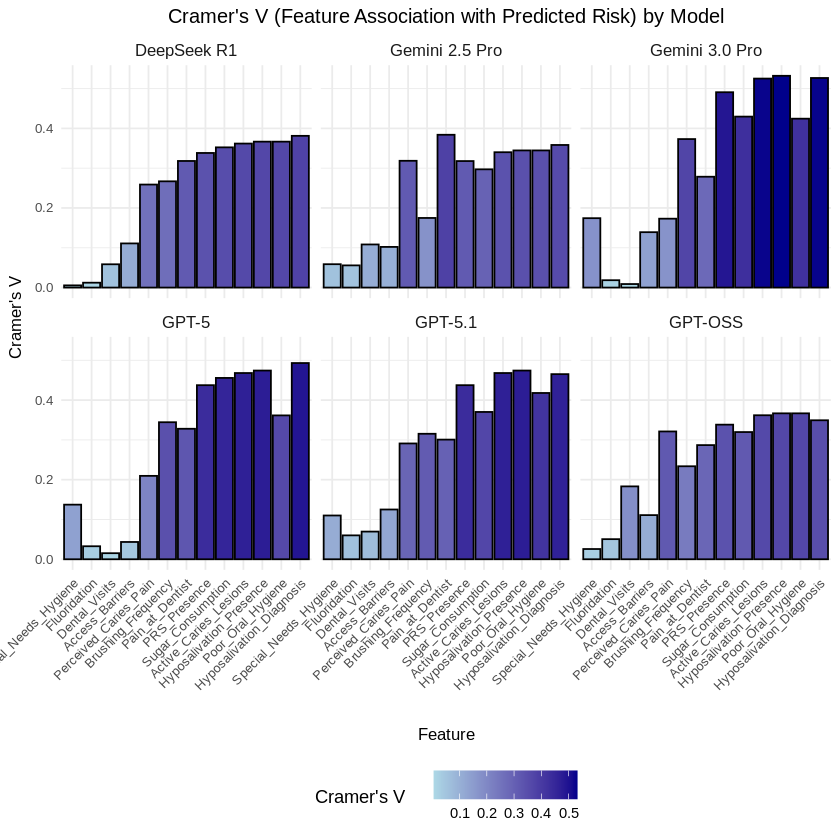

In [ ]:
model_name_mapping <- c(
  "gemini-3-pro-preview" = "Gemini 3.0 Pro",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "deepseek-r1" = "DeepSeek R1",
  "gpt-oss-120b" = "GPT-OSS"
)

# Prepare data for plotting, including display names and ordering features by Cramer's V
plot_data <- all_cramers_v_values %>%
  mutate(display_model_name = recode(model, !!!model_name_mapping)) %>%
  group_by(display_model_name) %>%
  mutate(feature = reorder(feature, cramers_v)) %>%
  ungroup()

# Create the bar plot
cramers_v_plot <- ggplot(plot_data, aes(x = feature, y = cramers_v, fill = cramers_v)) +
  geom_bar(stat = "identity", color = "black") +
  facet_wrap(~ display_model_name, ncol = 3) +
  labs(
    x = "Feature",
    y = "Cramer's V",
    title = "Cramer's V (Feature Association with Predicted Risk) by Model",
    fill = "Cramer's V"
  ) +
  scale_fill_gradient(low = "lightblue", high = "darkblue") + # Continuous color scale
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
    axis.text.y = element_text(size = 8),
    axis.title = element_text(size = 10),
    strip.text = element_text(size = 10),
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.5, size = 12)
  )

print(cramers_v_plot)

Save the generated `cramers_v_plot` to a JPEG file, following the pattern of saving previous plots to disk for reproducibility and easy sharing.



In [ ]:
jpeg("cramers_v_plot.jpg", width = 30, height = 20, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
print(cramers_v_plot)
dev.off()

agg_record_908657304 
                   2

## Consolidate and Rank Feature Importances

### Subtask:
Combine all calculated Cramer's V values into a single data frame. For each model, rank the input features by their Cramer's V values in descending order to identify the most influential variables for that specific model's predictions.


Group the 'all_cramers_v_values' DataFrame by 'model', then rank the features based on their 'cramers_v' values in descending order within each group, and finally display the head of the resulting 'ranked_cramers_v_values' DataFrame.



In [ ]:
ranked_cramers_v_values <- all_cramers_v_values %>%
  group_by(model) %>%
  arrange(desc(cramers_v)) %>%
  mutate(rank = row_number()) %>%
  ungroup()

cat("Head of ranked Cramer's V values:")
print(head(ranked_cramers_v_values))

Head of ranked Cramer's V values:# A tibble: 6 × 4
  model                feature                  cramers_v  rank
  <chr>                <chr>                        <dbl> <int>
1 gemini-3-pro-preview Hyposalivation_Presence      0.532     1
2 gemini-3-pro-preview Hyposalivation_Diagnosis     0.527     2
3 gemini-3-pro-preview Active_Caries_Lesions        0.525     3
4 gpt-5                Hyposalivation_Diagnosis     0.493     1
5 gemini-3-pro-preview PRS_Presence                 0.491     4
6 gpt-5                Hyposalivation_Presence      0.474     2


In [ ]:
write.csv(ranked_cramers_v_values, "ranked_cramers_v_values.csv", row.names = FALSE)
cat("ranked_cramers_v_values exported to ranked_cramers_v_values.csv")

ranked_cramers_v_values exported to ranked_cramers_v_values.csv

# Task
Define the original feature weights, then join these weights with the calculated Cramer's V values for each model and feature. Subsequently, calculate the correlation between the Cramer's V values and the original weights for each model, identify the model with the highest correlation, and finally display these correlation results.

## Define Original Weights

### Subtask:
Create a data frame containing the original feature weights.


Create a data frame named `original_weights_df` with the specified feature names and their corresponding weights, and then display its head to verify the content.



In [ ]:
original_weights_df <- data.frame(
  feature = c(
    "Fluoridation", "Dental_Visits", "Brushing_Frequency",
    "Perceived_Caries_Pain", "Access_Barriers", "Pain_at_Dentist",
    "Special_Needs_Hygiene", "Sugar_Consumption", "Hyposalivation_Diagnosis",
    "Hyposalivation_Presence", "PRS_Presence", "Active_Caries_Lesions",
    "Poor_Oral_Hygiene"
  ),
  weight = c(
    -2, -2, 40, 8, 13, 20, 20, 35, 76, 76, 76, 76, 40
  )
)

cat("\nHead of original_weights_df:\n")
print(head(original_weights_df))


Head of original_weights_df:
                feature weight
1          Fluoridation     -2
2         Dental_Visits     -2
3    Brushing_Frequency     40
4 Perceived_Caries_Pain      8
5       Access_Barriers     13
6       Pain_at_Dentist     20


## Join Cramer's V Values with Original Weights

### Subtask:
Merge the `all_cramers_v_values` data frame with the `original_weights_df` to align feature-specific Cramer's V values with their corresponding original weights for each model.


Perform a left join between `all_cramers_v_values` and `original_weights_df` using the 'feature' column to combine Cramer's V values with their corresponding original weights.



In [ ]:
merged_cramers_v_weights <- all_cramers_v_values %>%
  left_join(original_weights_df, by = "feature")

cat("\nHead of merged_cramers_v_weights:\n")
print(head(merged_cramers_v_weights))


Head of merged_cramers_v_weights:
        model               feature  cramers_v weight
1 deepseek-r1          Fluoridation 0.01224653     -2
2 deepseek-r1         Dental_Visits 0.05851395     -2
3 deepseek-r1    Brushing_Frequency 0.26700516     40
4 deepseek-r1 Perceived_Caries_Pain 0.25888544      8
5 deepseek-r1       Access_Barriers 0.11093201     13
6 deepseek-r1       Pain_at_Dentist 0.31814422     20


Calculate the Pearson correlation between the Cramer's V values and the original weights for each model. This involves grouping the merged data by model and applying the `cor` function.



In [ ]:
model_correlations <- merged_cramers_v_weights %>%
  group_by(model) %>%
  summarise(
    correlation = cor.test(cramers_v, weight, use = "complete.obs")$estimate, # Extract correlation estimate
    p_value = cor.test(cramers_v, weight, use = "complete.obs")$p.value # Extract p-value
  ) %>%
  arrange(desc(correlation)) # Arrange by correlation in descending order

cat("\nCorrelations between Cramer's V and Original Weights per Model (with p-value):\n")
print(model_correlations)


Correlations between Cramer's V and Original Weights per Model (with p-value):
# A tibble: 6 × 3
  model                correlation    p_value
  <chr>                      <dbl>      <dbl>
1 gemini-3-pro-preview       0.946 0.00000107
2 gpt-5.1                    0.888 0.0000510 
3 gpt-5                      0.883 0.0000625 
4 deepseek-r1                0.763 0.00240   
5 gpt-oss-120b               0.693 0.00860   
6 gemini-2.5-pro             0.646 0.0170    


`geom_smooth()` using formula = 'y ~ x'


agg_record_1375940621 
                    2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


agg_record_1375940621 
                    2

`geom_smooth()` using formula = 'y ~ x'


agg_record_1375940621 
                    2

agg_record_1375940621 
                    2

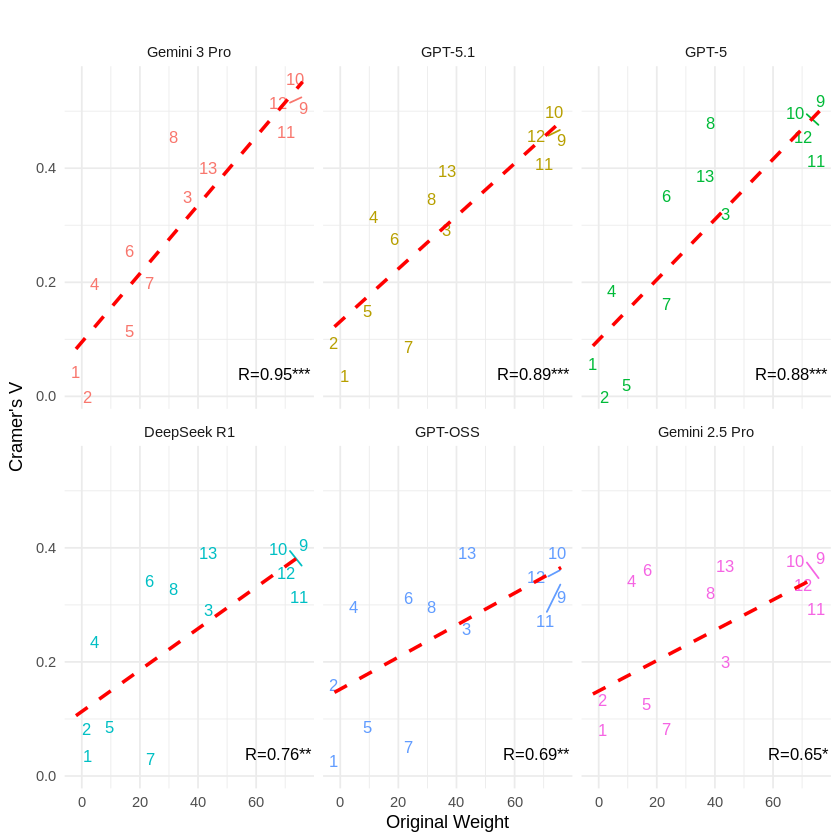

In [ ]:
if (!requireNamespace("ggrepel", quietly = TRUE)) {
  install.packages("ggrepel")
}
library(ggrepel)

# Define the model name mapping for consistent display names
model_name_mapping <- c(
  "gemini-3-pro-preview" = "Gemini 3 Pro",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "deepseek-r1" = "DeepSeek R1",
  "gpt-oss-120b" = "GPT-OSS"
)

# Calculate significance stars for model_correlations
model_correlations_with_sig <- model_correlations %>%
  mutate(sig_stars = case_when(
    p_value < 0.001 ~ "***",
    p_value < 0.01 ~ "**",
    p_value < 0.05 ~ "*",
    TRUE ~ ""
  ))

# --- Figure Option 1: Scatter Plot with Regression Line per Model (Original) ---
# Add display model names to the merged data
plot_data_scatter <- merged_cramers_v_weights %>%
  mutate(display_model_name = recode(model, !!!model_name_mapping))

# Order models by correlation for consistent faceting (highest correlation first)
ordered_models_for_plot <- model_correlations_with_sig %>%
  arrange(desc(correlation)) %>%
  pull(model)

plot_data_scatter$display_model_name <- factor(plot_data_scatter$display_model_name,
                                                 levels = recode(ordered_models_for_plot, !!!model_name_mapping))

scatter_plot_correlation <- ggplot(plot_data_scatter, aes(x = weight, y = cramers_v)) +
  geom_point(aes(color = display_model_name), alpha = 0.7) + # Color points by model
  geom_smooth(method = "lm", se = FALSE, color = "red", linetype = "dashed") + # Add regression line
  facet_wrap(~ display_model_name, scales = "free") + # Separate plot for each model
  labs(
    x = "Original Weight",
    y = "Cramer's V",
    title = "Correlación entre Cramer's V y Ponderaciones Originales por Modelo",
    color = "Modelo" # Legend title
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "none" # Hide legend as facets are already separated by model
  )

# # print(scatter_plot_correlation)

# Save the scatter plot
jpeg("scatter_plot_correlation.jpg", width = 25, height = 15, res = 300, quality = 100, units = "cm")
print(scatter_plot_correlation)
dev.off()


# --- Alternative Figure Option 1: Scatter Plot with Variable Numbers ---
# Create a mapping from feature names to numbers
feature_number_mapping <- data.frame(
  feature = new_column_names,
  feature_number = 1:length(new_column_names)
)

# Merge feature numbers into the plot data
plot_data_scatter_numbered <- plot_data_scatter %>%
  left_join(feature_number_mapping, by = "feature")

# Prepare labels for annotation in each facet
model_correlations_labels <- model_correlations_with_sig %>%
  mutate(
  correlation = round(correlation, 2),
    display_model_name = recode(model, !!!model_name_mapping),
    label_text = paste0("R=", sprintf("%.2f", round(correlation, 2)), sig_stars)
  ) %>%
  mutate(display_model_name = factor(display_model_name, levels = recode(ordered_models_for_plot, !!!model_name_mapping)))

scatter_plot_correlation_numbered <- ggplot(plot_data_scatter_numbered, aes(x = weight, y = cramers_v)) +
  geom_text_repel(aes(label = feature_number, color = display_model_name), size = 3.5, max.overlaps = Inf) + # Use geom_text_repel to avoid overlap
  geom_smooth(method = "lm", se = FALSE, color = "red", linetype = "dashed") + # Add regression line
  facet_wrap(~ display_model_name) + # , scales = "free" Separate plot for each model
  labs(
    x = "Original Weight",
    y = "Cramer's V",
    # title = "Correlación entre Cramer's V y Ponderaciones Originales por Modelo (Número de Variable)", # Removed title or keep it short
    title = "",
    color = "Modelo" # Legend title
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "none" # Hide legend as facets are already separated by model
  ) +
  geom_text(
    data = model_correlations_labels, # Use the prepared labels data
    aes(x = Inf, y = 0.05, label = label_text), # Position: top-right corner
    hjust = 1.05, vjust = 1.05, size = 3.5, color = "black",
    inherit.aes = FALSE # Crucial to prevent conflicts with main plot aesthetics
  )

set.seed(123)

print(scatter_plot_correlation_numbered)

# Save the numbered scatter plot
jpeg("scatter_plot_correlation_numbered.jpg", width = 15, height = 15, res = 300, quality = 100, units = "cm")
print(scatter_plot_correlation_numbered)
dev.off()

pdf("scatter_plot_correlation_numbered.pdf", width = 6, height = 6) # Adjust width and height as needed for PDF
print(scatter_plot_correlation_numbered)
dev.off()

# --- Figure Option 2: Bar Plot of Correlation Coefficients ---
# Add display model names to the correlation data
plot_data_bar <- model_correlations_with_sig %>%
  mutate(display_model_name = recode(model, !!!model_name_mapping))

# Order models by correlation for the bar plot
plot_data_bar$display_model_name <- factor(plot_data_bar$display_model_name,
                                             levels = plot_data_bar$display_model_name[order(plot_data_bar$correlation, decreasing = TRUE)])

bar_plot_correlation <- ggplot(plot_data_bar, aes(x = display_model_name, y = correlation, fill = display_model_name)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = sprintf("%.3f%s", correlation, sig_stars)), vjust = -0.5, size = 3) + # Add correlation values and stars as text
  labs(
    x = "Modelo",
    y = "Coeficiente de Correlación (Pearson)",
    title = "Correlación de Cramer's V vs. Ponderaciones Originales por Modelo",
    fill = "Modelo"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(hjust = 0.5),
    legend.position = "none" # Hide legend as bars are already labeled
  )

# # print(bar_plot_correlation)

# Save the bar plot
jpeg("bar_plot_correlation.jpg", width = 15, height = 10, res = 300, quality = 100, units = "cm")
print(bar_plot_correlation)
dev.off()


In [ ]:
model_correlations_labels

model,correlation,p_value,sig_stars,display_model_name,label_text
<chr>,<dbl>,<dbl>,<chr>,<fct>,<chr>
gemini-3-pro-preview,0.95,1.070571e-06,***,Gemini 3.0 Pro,R=0.95***
gpt-5.1,0.89,5.103820e-05,***,GPT-5.1,R=0.89***
gpt-5,0.88,6.247254e-05,***,GPT-5,R=0.88***
deepseek-r1,0.76,2.400546e-03,**,DeepSeek R1,R=0.76**
gpt-oss-120b,0.69,8.601507e-03,**,GPT-OSS,R=0.69**
gemini-2.5-pro,0.65,1.697744e-02,*,Gemini 2.5 Pro,R=0.65*


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


agg_record_169544877 
                   2

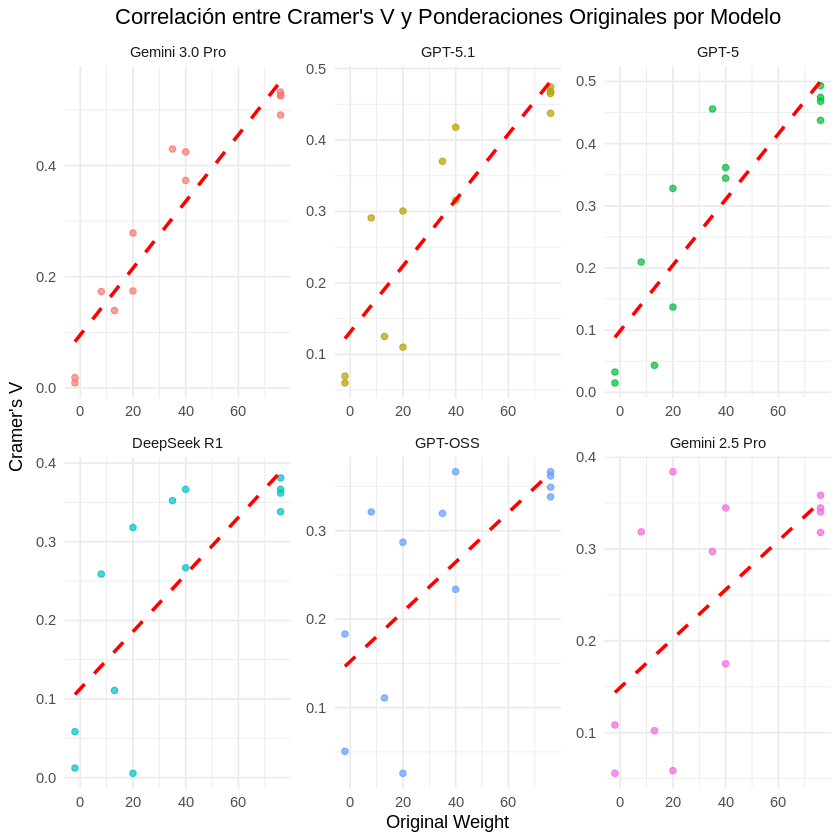

agg_record_169544877 
                   2

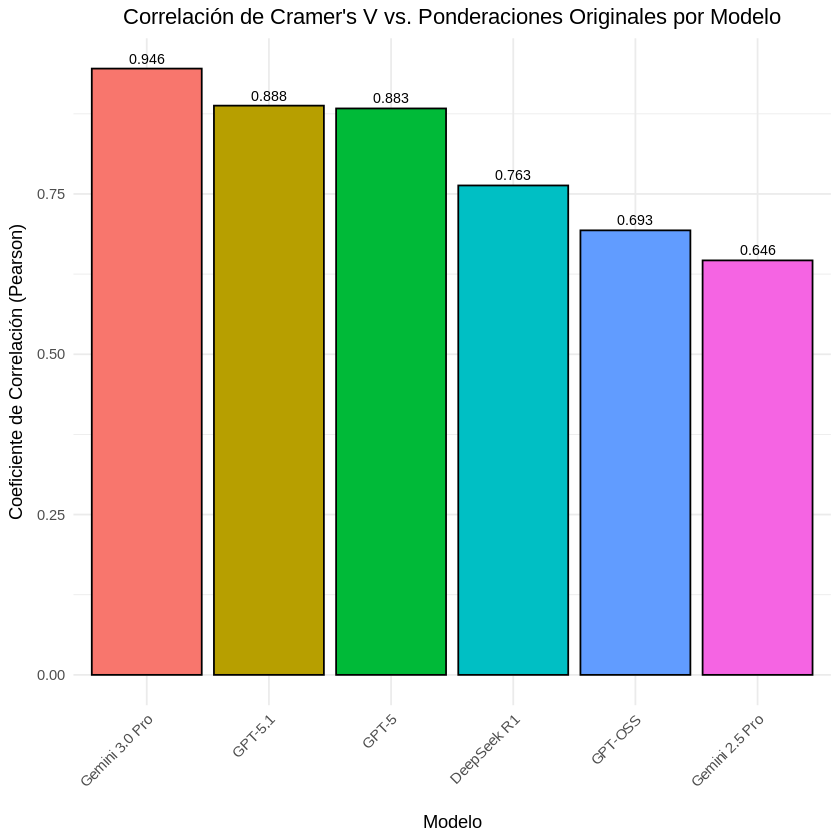

In [ ]:
# Option with numbers
model_name_mapping <- c(
  "gemini-3-pro-preview" = "Gemini 3.0 Pro",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "deepseek-r1" = "DeepSeek R1",
  "gpt-oss-120b" = "GPT-OSS"
)

# --- Figure Option 1: Scatter Plot with Regression Line per Model ---
# Add display model names to the merged data
plot_data_scatter <- merged_cramers_v_weights %>%
  mutate(display_model_name = recode(model, !!!model_name_mapping))

# Order models by correlation for consistent faceting (highest correlation first)
ordered_models_for_plot <- model_correlations %>%
  arrange(desc(correlation)) %>%
  pull(model)

plot_data_scatter$display_model_name <- factor(plot_data_scatter$display_model_name,
                                                 levels = recode(ordered_models_for_plot, !!!model_name_mapping))

scatter_plot_correlation <- ggplot(plot_data_scatter, aes(x = weight, y = cramers_v)) +
  geom_point(aes(color = display_model_name), alpha = 0.7) + # Color points by model
  geom_smooth(method = "lm", se = FALSE, color = "red", linetype = "dashed") + # Add regression line
  facet_wrap(~ display_model_name, scales = "free") + # Separate plot for each model
  labs(
    x = "Original Weight",
    y = "Cramer's V",
    title = "Correlación entre Cramer's V y Ponderaciones Originales por Modelo",
    color = "Modelo" # Legend title
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "none" # Hide legend as facets are already separated by model
  )

print(scatter_plot_correlation)

# Save the scatter plot
jpeg("scatter_plot_correlation.jpg", width = 25, height = 15, res = 300, quality = 100, units = "cm")
print(scatter_plot_correlation)
dev.off()

# --- Figure Option 2: Bar Plot of Correlation Coefficients ---
# Add display model names to the correlation data
plot_data_bar <- model_correlations %>%
  mutate(display_model_name = recode(model, !!!model_name_mapping))

# Order models by correlation for the bar plot
plot_data_bar$display_model_name <- factor(plot_data_bar$display_model_name,
                                             levels = plot_data_bar$display_model_name[order(plot_data_bar$correlation, decreasing = TRUE)])

bar_plot_correlation <- ggplot(plot_data_bar, aes(x = display_model_name, y = correlation, fill = display_model_name)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = sprintf("%.3f", correlation)), vjust = -0.5, size = 3) + # Add correlation values as text
  labs(
    x = "Modelo",
    y = "Coeficiente de Correlación (Pearson)",
    title = "Correlación de Cramer's V vs. Ponderaciones Originales por Modelo",
    fill = "Modelo"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(hjust = 0.5),
    legend.position = "none" # Hide legend as bars are already labeled
  )

print(bar_plot_correlation)

# Save the bar plot
jpeg("bar_plot_correlation.jpg", width = 15, height = 10, res = 300, quality = 100, units = "cm")
print(bar_plot_correlation)
dev.off()

# Task
Calculate Cramer's V and p-values for each unique model and input feature.

## Calculate Cramer's V and p-values

### Subtask:
Iterate through each unique model and each input feature. For each combination, calculate Cramer's V and its corresponding p-value using the `assocstats` function. Store these values along with the model and feature names in a new data frame.


Initialize an empty list to store the results, then iterate through each model and each input feature. For each combination, create a contingency table between the feature and the 'moda' column, calculate Cramer's V and its p-value using `assocstats`, and store these metrics along with the model and feature names. Finally, combine all results into a single data frame and display its head.



In [ ]:
cramers_v_p_values_results <- list()

unique_models <- unique(unified_excel_df$modelo)

for (model_name_val in unique_models) {
  model_subset <- unified_excel_df %>% filter(modelo == model_name_val)

  for (feature_name in new_column_names) {
    # Ensure the feature column is treated as categorical (factor)
    # and filter out NAs if any in the feature or 'moda' column for the current subset
    contingency_table <- table(model_subset[[feature_name]], model_subset$moda)

    # Check if the table has at least one non-zero row and column for assocstats
    # and at least 2 categories for both variables
    if (sum(contingency_table) > 0 && nrow(contingency_table) > 1 && ncol(contingency_table) > 1) {
      # Calculate association statistics
      assoc_stats <- assocstats(contingency_table)
      cramers_v <- assoc_stats$cramer
      p_value <- assoc_stats$chisq_tests["Pearson", "P(> X^2)"]
    } else {
      cramers_v <- NA # Assign NA if table is not suitable for Cramer's V calculation
      p_value <- NA   # Assign NA for p-value as well
    }

    cramers_v_p_values_results <- bind_rows(cramers_v_p_values_results, data.frame(
      model = model_name_val,
      feature = feature_name,
      cramers_v = cramers_v,
      p_value = p_value
    ))
  }
}

all_cramers_v_p_values <- bind_rows(cramers_v_p_values_results)

cat("Head of Cramer's V and p-values per model and feature:\n")
print(head(all_cramers_v_p_values))

Head of Cramer's V and p-values per model and feature:
        model               feature  cramers_v      p_value
1 deepseek-r1          Fluoridation 0.03720729 6.337283e-01
2 deepseek-r1         Dental_Visits 0.07465073 3.390744e-01
3 deepseek-r1    Brushing_Frequency 0.22578230 3.835001e-03
4 deepseek-r1 Perceived_Caries_Pain 0.21505385 5.886583e-03
5 deepseek-r1       Access_Barriers 0.06590344 3.986829e-01
6 deepseek-r1       Pain_at_Dentist 0.43435403 2.660199e-08


## Display Cramer's V and p-values

### Subtask:
Display the head of the data frame containing Cramer's V values and their associated p-values to review the newly calculated results.


Print the head of the `all_cramers_v_p_values` data frame to display the calculated Cramer's V values and their associated p-values.



In [ ]:
print(tail(all_cramers_v_p_values))

          model                  feature cramers_v      p_value
73 gpt-oss-120b        Sugar_Consumption 0.3270520 2.810404e-05
74 gpt-oss-120b Hyposalivation_Diagnosis 0.3572301 4.767260e-06
75 gpt-oss-120b  Hyposalivation_Presence 0.3739788 1.673930e-06
76 gpt-oss-120b             PRS_Presence 0.3449757 9.968982e-06
77 gpt-oss-120b    Active_Caries_Lesions 0.3690790 2.284027e-06
78 gpt-oss-120b        Poor_Oral_Hygiene 0.3739788 1.673930e-06


In [ ]:
all_cramers_v_p_values_rounded <- all_cramers_v_p_values %>%
  mutate(
    cramers_v = round(cramers_v, 4),
    p_value = round(p_value, 4)
  )

write.csv(all_cramers_v_p_values_rounded, "all_cramers_v_p_values.csv", row.names = FALSE)

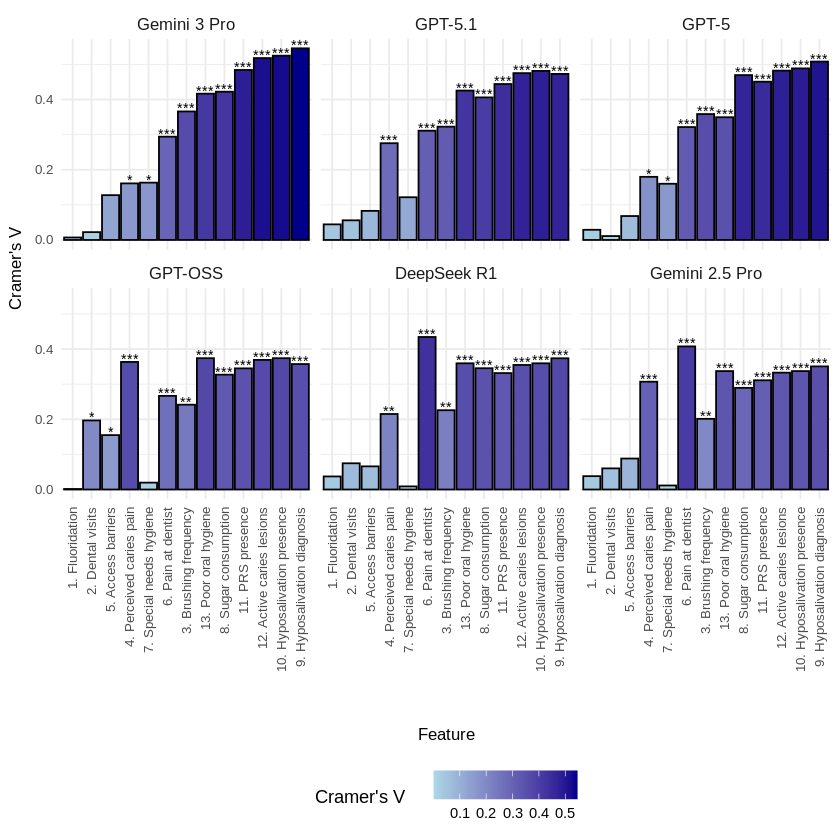

In [ ]:
# Cramers plot with significance *
model_name_mapping <- c(
  "gemini-3-pro-preview" = "Gemini 3 Pro",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "deepseek-r1" = "DeepSeek R1",
  "gpt-oss-120b" = "GPT-OSS"
)

# User-provided descriptive feature names
user_display_names <- c(
  "1. Fluoridation",
  "2. Dental visits",
  "3. Brushing frequency",
  "4. Perceived caries pain",
  "5. Access barriers",
  "6. Pain at dentist",
  "7. Special needs hygiene",
  "8. Sugar consumption",
  "9. Hyposalivation diagnosis",
  "10. Hyposalivation presence",
  "11. PRS presence",
  "12. Active caries lesions",
  "13. Poor oral hygiene"
)

# Create the mapping: short_name = "Long display name" using the existing new_column_names
feature_display_names_map <- setNames(user_display_names, new_column_names)

# Define the desired order for the facets
desired_facet_order <- c(
  "Gemini 3 Pro",
  "GPT-5.1",
  "GPT-5",
  "GPT-OSS",
  "DeepSeek R1",
  "Gemini 2.5 Pro"
)

# Temporary plot_data for ordering features based on Gemini 3 Pro
plot_data_temp_for_order <- all_cramers_v_p_values %>%
  mutate(display_model_name = recode(model, !!!model_name_mapping)) %>%
  mutate(feature_display = recode(feature, !!!feature_display_names_map))

gemini_3_pro_order <- plot_data_temp_for_order %>%
  filter(display_model_name == "Gemini 3 Pro") %>%
  arrange(cramers_v) %>%
  pull(feature_display)

# Prepare data for plotting, including display names, p-values, and ordering features by Cramer's V
plot_data <- all_cramers_v_p_values %>%
  mutate(display_model_name = recode(model, !!!model_name_mapping)) %>%
  # Apply new descriptive feature names
  mutate(feature_display = recode(feature, !!!feature_display_names_map)) %>%
  # Determine significance label
  mutate(sig_label = case_when(
    p_value < 0.001 ~ "***",
    p_value < 0.01 ~ "**",
    p_value < 0.05 ~ "*",
    TRUE ~ ""
  )) %>%
  group_by(display_model_name) %>%
  # Reorder features based on Gemini 3 Pro's Cramer's V values
  mutate(feature_display = factor(feature_display, levels = gemini_3_pro_order)) %>%
  ungroup() %>%
  # Set the order of the display_model_name factor for facet ordering
  mutate(display_model_name = factor(display_model_name, levels = desired_facet_order))

# Create the bar plot
cramers_v_plot <- ggplot(plot_data, aes(x = feature_display, y = cramers_v, fill = cramers_v)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = sig_label), # Use new significance label
            vjust = 0.2,
            size = 3,
            color = 'black') +
  facet_wrap(~ display_model_name, ncol = 3) +
  labs(
    x = "Feature",
    y = "Cramer's V",
    # title = "Cramer's V (Feature Association with Predicted Risk) by Model",
    fill = "Cramer's V"
  ) +
  scale_fill_gradient(low = "lightblue", high = "darkblue") + # Continuous color scale
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 8), # Adjusted x-axis labels
    axis.text.y = element_text(size = 8),
    axis.title = element_text(size = 10),
    strip.text = element_text(size = 10),
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.5, size = 12)
  )

print(cramers_v_plot)

In [ ]:
jpeg("cramers_v_plot.jpg", width = 16, height = 16, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
print(cramers_v_plot)
dev.off()

agg_record_745464807 
                   2

In [ ]:
pdf("cramers_v_plot.pdf", width = 6, height = 6) # Adjust width and height as needed for PDF
print(cramers_v_plot)
dev.off()

agg_record_404881713 
                   2

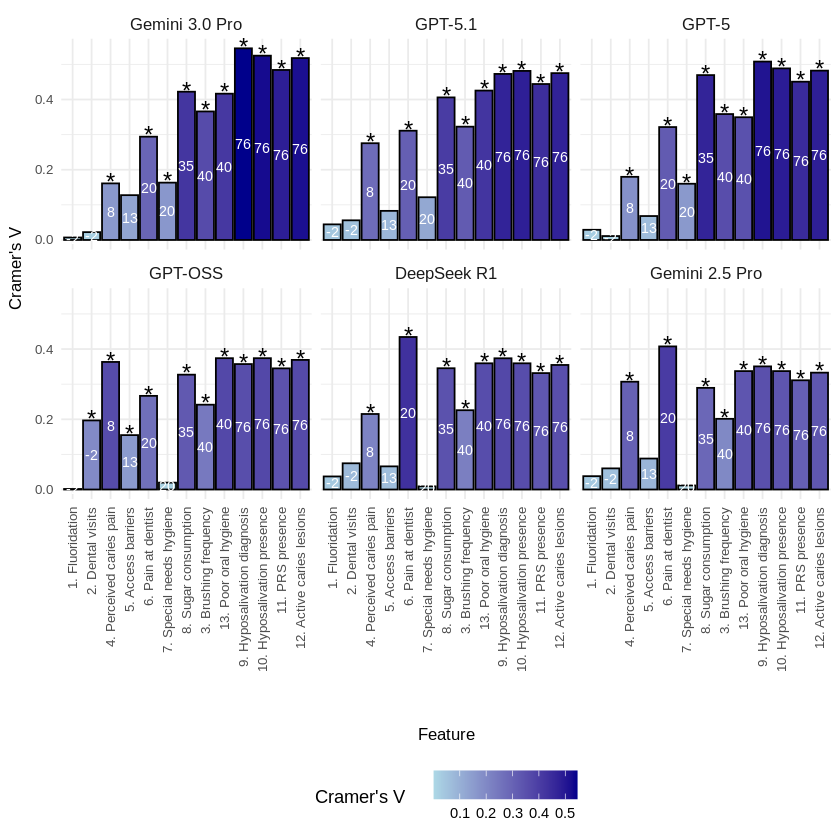

In [ ]:
# original weights order
model_name_mapping <- c(
  "gemini-3-pro-preview" = "Gemini 3.0 Pro",
  "gemini-2.5-pro" = "Gemini 2.5 Pro",
  "gpt-5" = "GPT-5",
  "gpt-5.1" = "GPT-5.1",
  "deepseek-r1" = "DeepSeek R1",
  "gpt-oss-120b" = "GPT-OSS"
)

# User-provided descriptive feature names
user_display_names <- c(
  "1. Fluoridation",
  "2. Dental visits",
  "3. Brushing frequency",
  "4. Perceived caries pain",
  "5. Access barriers",
  "6. Pain at dentist",
  "7. Special needs hygiene",
  "8. Sugar consumption",
  "9. Hyposalivation diagnosis",
  "10. Hyposalivation presence",
  "11. PRS presence",
  "12. Active caries lesions",
  "13. Poor oral hygiene"
)

# Create the mapping: short_name = "Long display name" using the existing new_column_names
feature_display_names_map <- setNames(user_display_names, new_column_names)

# Define the desired order for the facets
desired_facet_order <- c(
  "Gemini 3.0 Pro",
  "GPT-5.1",
  "GPT-5",
  "GPT-OSS",
  "DeepSeek R1",
  "Gemini 2.5 Pro"
)

# Get the order of features based on their original weights
ordered_features_by_weight <- original_weights_df %>%
  arrange(weight) %>%
  pull(feature)

# Map the ordered short feature names to their display names
ordered_display_features_by_weight <- recode(ordered_features_by_weight, !!!feature_display_names_map)

# Prepare data for plotting, including display names, p-values, and ordering features by Cramer's V
plot_data <- all_cramers_v_p_values %>%
  left_join(original_weights_df, by = "feature") %>%
  mutate(display_model_name = recode(model, !!!model_name_mapping)) %>%
  # Apply new descriptive feature names
  mutate(feature_display = recode(feature, !!!feature_display_names_map)) %>%
  # Determine significance
  mutate(significant = p_value < 0.05) %>%
  group_by(display_model_name) %>%
  # Reorder features based on original weights
  mutate(feature_display = factor(feature_display, levels = ordered_display_features_by_weight)) %>%
  ungroup() %>%
  # Set the order of the display_model_name factor for facet ordering
  mutate(display_model_name = factor(display_model_name, levels = desired_facet_order))

# Create the bar plot
cramers_v_plot <- ggplot(plot_data, aes(x = feature_display, y = cramers_v, fill = cramers_v)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = ifelse(significant, '*', '')), # Add asterisk for significant features
            vjust = 0.4, # Position above the bar
            size = 5,
            color = 'black') +
  geom_text(aes(label = weight, y = cramers_v / 2), # Add weight label in the middle of the bar
            size = 3, # Adjust size for readability
            color = 'white') + # Adjust color for contrast
  facet_wrap(~ display_model_name, ncol = 3) +
  labs(
    x = "Feature",
    y = "Cramer's V",
    # title = "Cramer's V (Feature Association with Predicted Risk) by Model",
    fill = "Cramer's V"
  ) +
  scale_fill_gradient(low = "lightblue", high = "darkblue") + # Continuous color scale
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 8), # Adjusted x-axis labels
    axis.text.y = element_text(size = 8),
    axis.title = element_text(size = 10),
    strip.text = element_text(size = 10),
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.5, size = 12)
  )

print(cramers_v_plot)


In [ ]:
original_weights_df

feature,weight
<chr>,<dbl>
Fluoridation,-2
Dental_Visits,-2
Brushing_Frequency,40
Perceived_Caries_Pain,8
Access_Barriers,13
Pain_at_Dentist,20
Special_Needs_Hygiene,20
Sugar_Consumption,35
Hyposalivation_Diagnosis,76


In [ ]:
jpeg("cramers_v_plot.jpg", width = 18, height = 18, res = 300, quality = 100, units = "cm") # Adjust width, height, and res as needed
print(cramers_v_plot)
dev.off()

agg_record_540590808 
                   2